In [1]:
# Imports
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from ipywidgets import interact
from skimage.morphology import skeletonize
from skimage.measure import profile_line
from scipy.signal import find_peaks
import pandas as pd
from collections import defaultdict
import networkx as nx
import seaborn as sns
import matplotlib.cm as cm
from ipywidgets import interact, IntSlider
import matplotlib.lines as mlines
import matplotlib as mpl

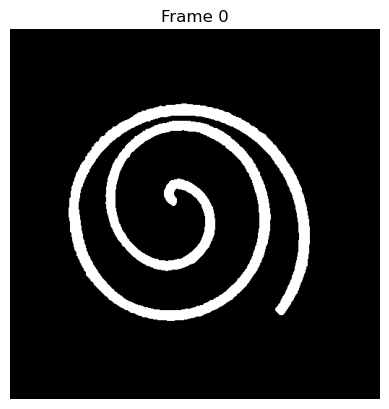

In [2]:
# Input is a mask of a maximum z projection of the spiral only channel
    # in tif format
mask_stack = tiff.imread("MASk_12_no_cells.tif")

# Preview first frame to check mask
plt.imshow(mask_stack[0], cmap='gray')
plt.title("Frame 0")
plt.axis('off')
plt.show()


In [3]:
#skeletonize all frames

#define array for skeletons
skel_stack = np.empty_like(mask_stack, dtype=bool) 

#Loop over frames to skeletonize
for t in range(len(skel_stack)):
    skel_stack[t] = skeletonize(mask_stack[t])

@interact(frame=(0, len(skel_stack)-1))
def view_contour(frame=0):
    plt.figure(figsize=(6,6))
    # Show mask or original image
    plt.imshow(skel_stack[frame], cmap='gray')

    plt.title(f"Frame {frame} skeleton")
    plt.axis('off')
    plt.show()


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

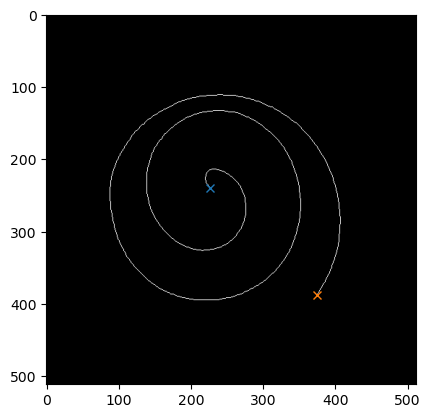

In [4]:
#Fuction to define the endpoints
def find_endpoints(skel: np.ndarray) -> list[np.ndarray, np.ndarray]:
    coords = np.argwhere(skel.T)
    ends = []
    for (x, y) in coords:
        c = np.sum(skel[y-1:y+2, x-1:x+2])
        if c <= 2:
            ends.append(np.array((x, y)))
    if len(ends) != 2:
        raise ValueError(f"Found {len(ends)} endpoints, but there should only be 2!")
    return ends


#try for the first frame
ends = find_endpoints(skel_stack[0])

plt.imshow(skel_stack[0], cmap="grey")
for end in ends:
    plt.plot(end[0], end[1], "x")
plt.show()

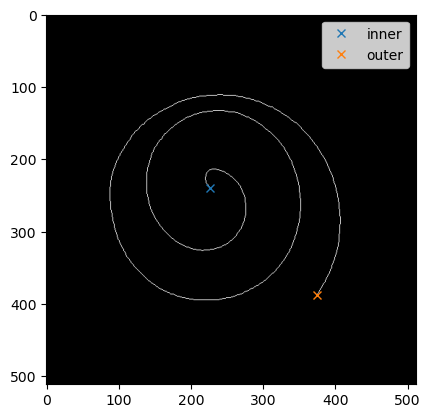

In [5]:
#Function to define inner and outer endpoint of the spiral, through distances to each other coordinate
def sort_endpoints(end1: np.ndarray, end2: np.ndarray, skel: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    coords = np.argwhere(skel.T)
    d1 = np.sum((coords - end1)**2)
    d2 = np.sum((coords - end2)**2)
    inner, outer = end1, end2
    if d1 > d2:
        inner, outer = end2, end1
    return inner, outer


#Try for first frame
inner, outer = sort_endpoints(*ends, skel_stack[0])
plt.imshow(skel_stack[0], cmap="grey")
plt.plot(*inner, "x", label="inner")
plt.plot(*outer, "x", label="outer")
plt.legend()
plt.show()

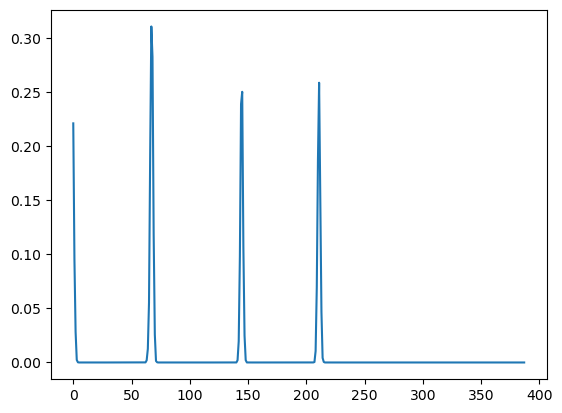

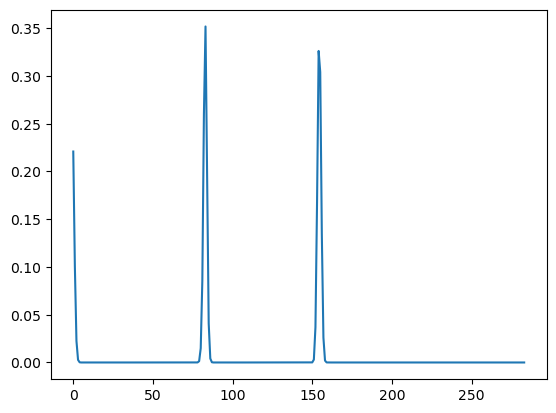

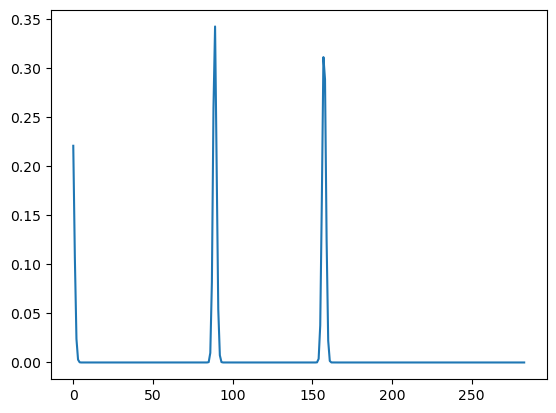

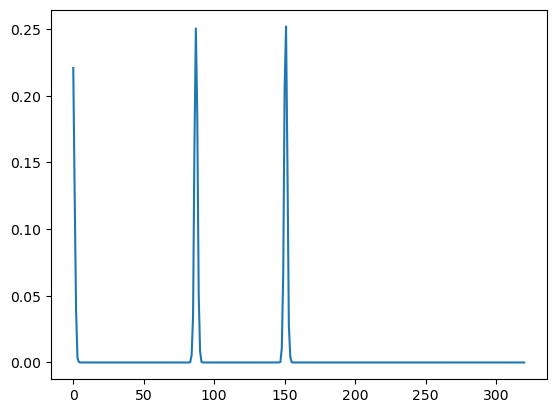

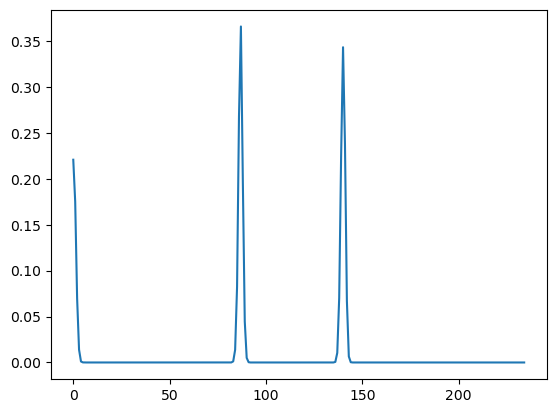

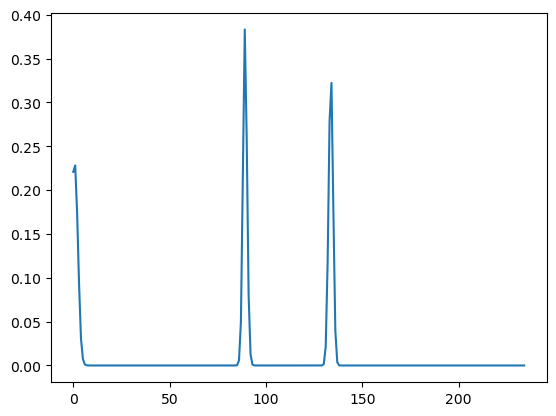

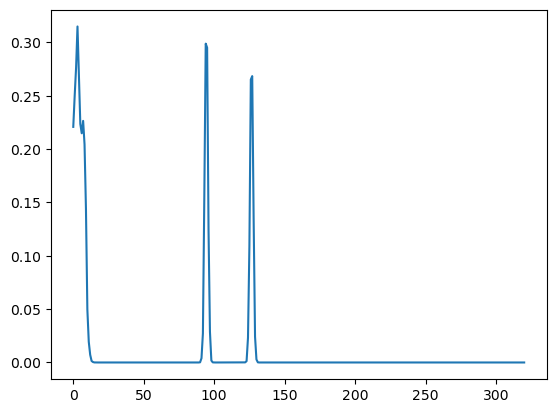

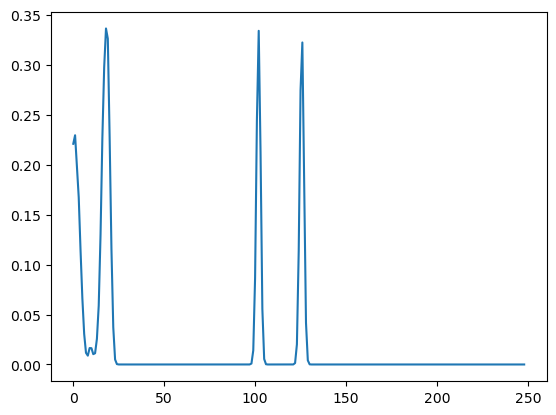

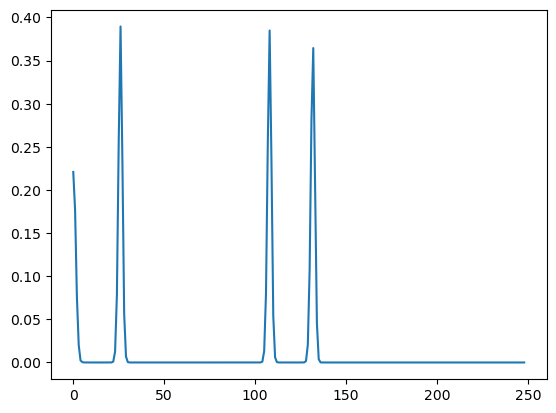

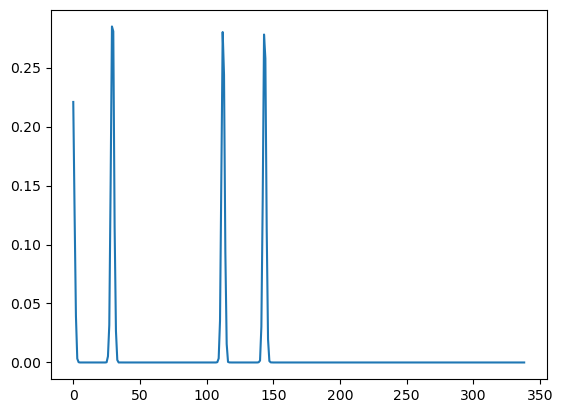

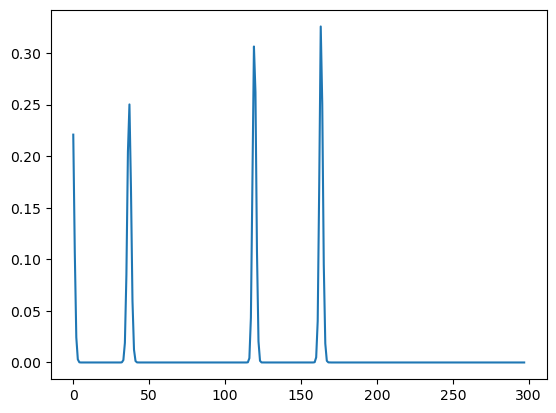

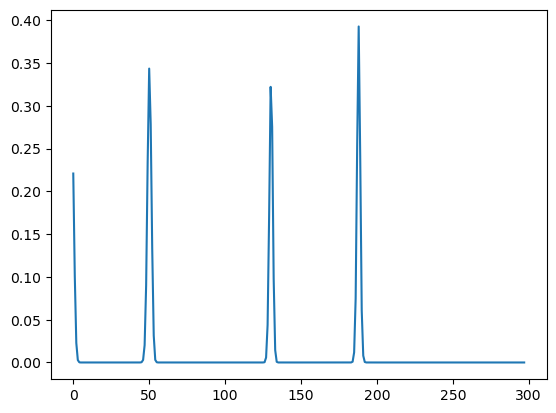

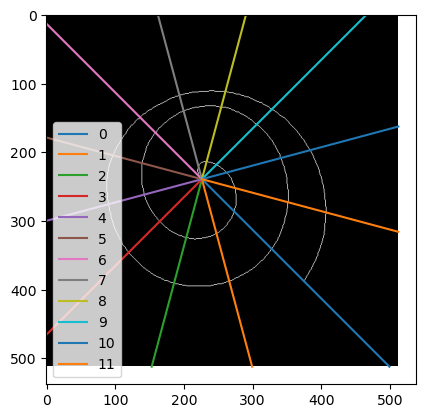

In [6]:
#function which alows border/ end definition for the rays
def aabb_line_intersection(
    aabb: tuple[float, float, float, float],
    a: np.ndarray,
    b: np.ndarray,
) -> tuple[float, float]:
    """Find the two values of `t` of intersection points of  the line `x = a +
    t*b` with the axis aligned bounding box via Liang-Barsky line clipping [3].
    Based on https://www.geeksforgeeks.org/liang-barsky-algorithm/

    Parameter
    ---------
    aabb: array_like of float
        Axis aligned bounding box `(xmin, ymin, xmax, ymax)`
    a, b: (2, ) ndarray of float
        Anchor point and direction vector of the line `x = a + t*b`

    Return
    ------
    dst: float
        Intersection of aabb with a+t*b in direction of b

    Raise
    -----
    ValueError
        If there is no intersection
    """
    with np.printoptions(precision=3):
        err = ValueError(f"Line x={a}.T+t*{b}.T and bounding box {aabb} do not intersect.")

    tsrc = -np.inf
    tdst = +np.inf

    pq = [
        (-b[0], a[0] - aabb[0]),
        (b[0], aabb[2] - a[0]),
        (-b[1], a[1] - aabb[1]),
        (b[1], aabb[3] - a[1]),
    ]

    for p, q in pq:
        if p == 0:
            if q < 0:
                raise err
        else:
            t = q / p
            if p < 0:
                tsrc = max(tsrc, t)
            else:
                tdst = min(tdst, t)
    if tsrc > tdst:
        raise err
    return a + tdst*b


#Function to cast the rays along which to measure
def cast_rays(inner: np.ndarray, outer: np.ndarray, skel: np.ndarray, angles: np.ndarray) -> list[np.ndarray]:
    profiles = []
    destinations = []
    b0 = outer-inner #Null linie
    theta0 = np.atan2(b0[1], b0[0]) #calculate angle from coordinates

    for theta in angles+theta0: #define angles
        b = np.array((np.cos(theta), np.sin(theta))) #Richtungsvektor
        dst = aabb_line_intersection([0, 0, skel.shape[1], skel.shape[0]], inner, b) #destination vom profile
        profile = profile_line(skel, inner[::-1], dst[::-1], linewidth=1, mode="constant") # profile line takes coordinates in [y, x] order
        profiles.append(profile)
        destinations.append(dst)
    return profiles, destinations

#smooth the input
from skimage.filters import gaussian
profiles, destinations = cast_rays(inner, outer, gaussian(skel_stack[0]), np.deg2rad(np.arange(0, 360, 30)))

for p in profiles:
    plt.plot(p)
    plt.show()

#try for first frame
plt.imshow(skel_stack[0], cmap="grey")
for i, dst in enumerate(destinations):
    plt.plot([inner[0], dst[0]], [inner[1], dst[1]], label=i)
plt.legend()
plt.show()

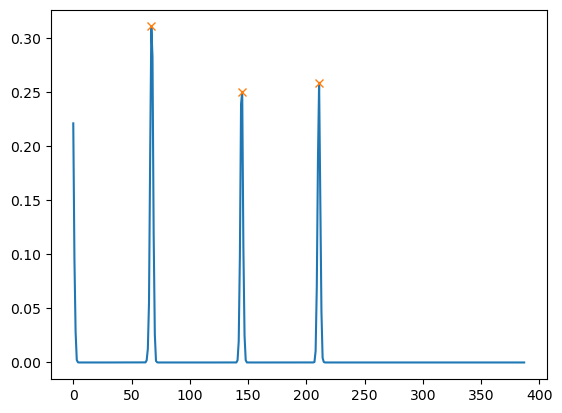

[67 78 66]


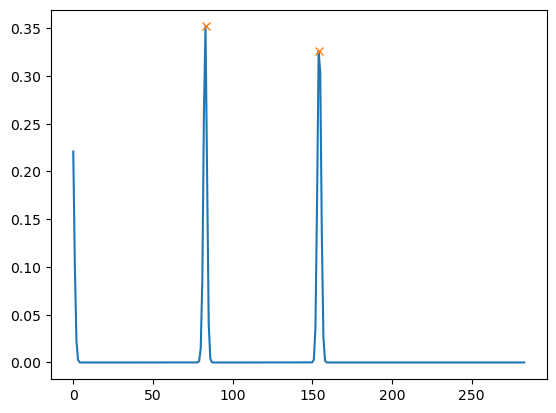

[83 71]


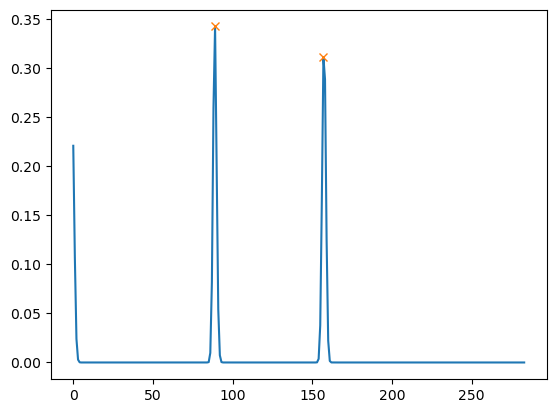

[89 68]


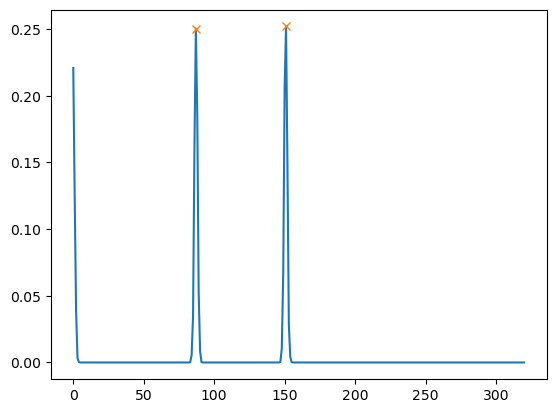

[87 64]


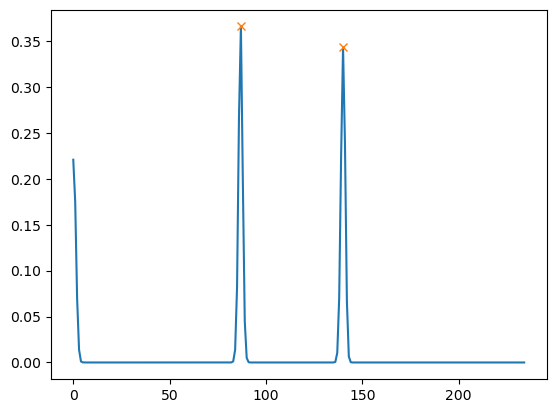

[87 53]


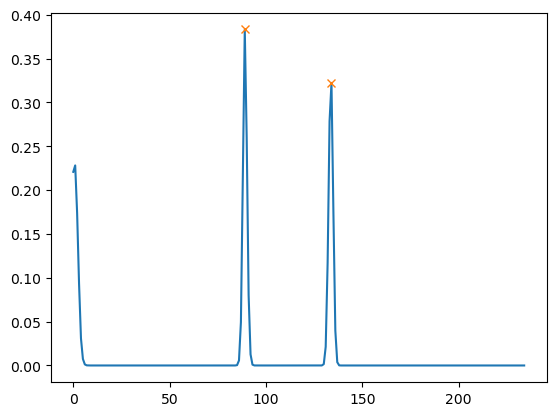

[89 45]


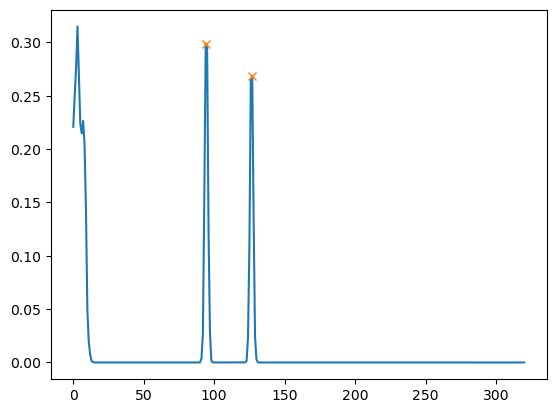

[94 33]


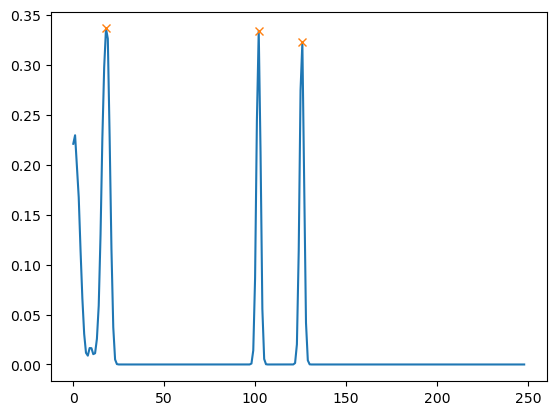

[18 84 24]


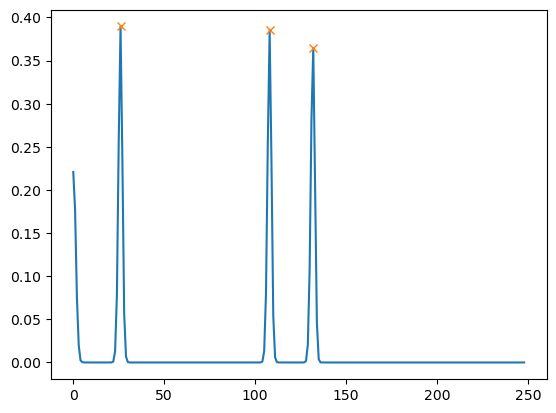

[26 82 24]


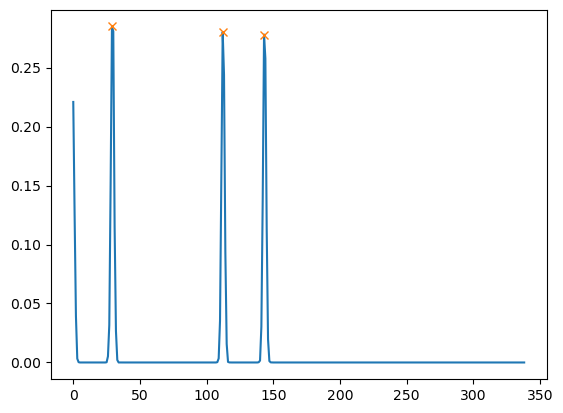

[29 83 31]


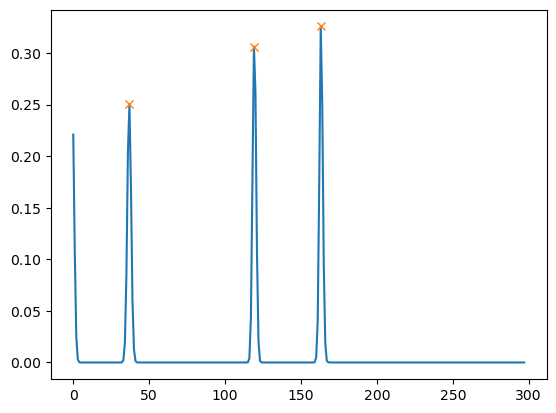

[37 82 44]


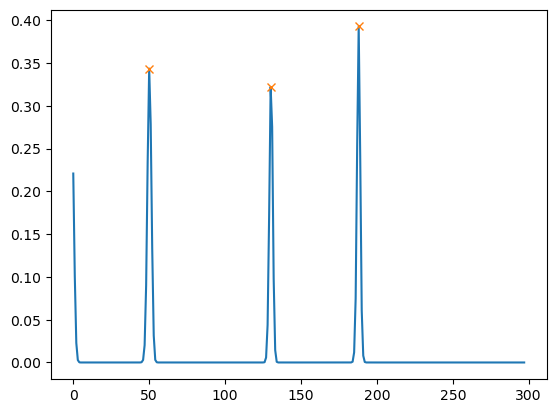

[50 80 58]


In [7]:
#function for peak detection
def find_spiral_intersections(profile):
    #add 0 so first peak is detectible
    profile = np.hstack(([0], profile))
    peaks, _ = find_peaks(profile, prominence=0.1)
    # remove offset by 1 element due to leading 0
    return peaks[1:]-1 

for p in profiles:
    plt.plot(p)
    peaks = find_spiral_intersections(p)
    plt.plot(peaks, p[peaks], "x")
    plt.show()
    print(np.diff(peaks, prepend=0))

In [8]:
#obtain the main skeleton to leave out artefacts

#build and adjacency graph
    #turns skeleton into a network of connected nodes
    #for each pixel 8 pixels around it are checked -> if also skeleton then connected -> list of neighbors of each pixel

#build a fuction for one skeleton frame
def build_adjacency_graph(skel):
    """
    Input:
        skel: 2D boolean array (skeleton)
    Output:
        coords: list of (y,x) skeleton pixel coordinates
        adj: dict mapping (y,x) -> list of neighbor coordinates
    """
    H, W = skel.shape
    coords = np.argwhere(skel)  # all skeleton pixels as (y,x)
    coords = [tuple(c) for c in coords]

    adj = defaultdict(list)
    for y, x in coords:
        # check 8 neighbors
        for dy in [-1,0,1]:
            for dx in [-1,0,1]:
                if dy==0 and dx==0:
                    continue
                ny, nx = y+dy, x+dx
                if 0 <= ny < H and 0 <= nx < W:
                    if skel[ny, nx]:
                        adj[(y,x)].append((ny,nx))
    return coords, adj

#for all frames
all_graphs = []

for t in range(len(skel_stack)):
    coords, adj = build_adjacency_graph(skel_stack[t])
    all_graphs.append((coords, adj))

# Function to extract main branch from adjacency graph
def get_main_branch(coords, adj):
    """
    Input:
        coords: list of (y,x) skeleton pixels
        adj: dict mapping (y,x) -> list of neighbor coordinates
    Output:
        main_branch: ordered list of (y,x) pixels of the main spiral
    """
    # --- Build NetworkX graph ---
    G = nx.Graph()
    G.add_nodes_from(coords)
    for node, neighbors in adj.items():
        for n in neighbors:
            G.add_edge(node, n)
    
    # --- Find connected components ---
    components = list(nx.connected_components(G))
    
    # --- Choose the largest component (assumed main spiral) ---
    main_component = max(components, key=len)
    
    # --- Find endpoints (nodes with degree 1) ---
    subG = G.subgraph(main_component)
    degrees = dict(subG.degree())
    endpoints = [n for n,d in degrees.items() if d==1]
    
    # --- Longest path between endpoints ---
    if len(endpoints) >= 2:
        max_path = []
        for i in range(len(endpoints)):
            for j in range(i+1, len(endpoints)):
                try:
                    path = nx.shortest_path(subG, source=endpoints[i], target=endpoints[j])
                    if len(path) > len(max_path):
                        max_path = path
                except:
                    continue
        main_branch = np.array(max_path)
    else:
        main_branch = np.array(list(main_component))
    
    return main_branch


main_branches = []

for t in range(len(skel_stack)):
    coords, adj = all_graphs[t]
    main_branch = get_main_branch(coords, adj)
    main_branches.append(main_branch)

@interact(frame=(0, len(skel_stack)-1))
def view_main_branch(frame=0):
    plt.figure(figsize=(6,6))
    plt.imshow(skel_stack[frame], cmap='gray')  # skeleton background
    branch = main_branches[frame]
    plt.scatter(branch[:,1], branch[:,0], c='red', s=5)  # main spiral in red
    plt.title(f"Frame {frame}: Main spiral branch")
    plt.axis('off')
    plt.show()

#convert main branch back into 2D image so it can be read
def branch_to_image(branch, shape):
    """
    Convert a list/array of (y,x) coordinates to a 2D boolean array.
    """
    img = np.zeros(shape, dtype=bool)
    img[branch[:,0], branch[:,1]] = True
    return img

# Convert all main branches to 2D skeleton images first
branch_images = []

for t in range(len(main_branches)):
    branch_img = np.zeros(skel_stack[t].shape, dtype=bool)
    branch_img[main_branches[t][:,0], main_branches[t][:,1]] = True
    branch_images.append(branch_img)


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

In [9]:
#Find ends Loop over frames 
ends_stack = []

for t in range(len(branch_images)):
    ends = find_endpoints(branch_images[t])
    ends_stack.append(ends)

#check how many ends are found
print(len(ends_stack))
print([len(e) for e in ends_stack])


@interact(frame=(0, len(branch_images)-1))
def view_skeleton_with_endpoints(frame=0):
    plt.figure(figsize=(6,6))
    
    # Show the original skeleton as background
    plt.imshow(branch_images[frame], cmap='gray')
    
    
    # Overlay the endpoints
    for end in ends_stack[frame]:
        # end is (y, x)
        plt.plot(end[0], end[1], 'bx', markersize=10, label='endpoint')
    
    plt.title(f"Frame {frame}: Main spiral with endpoints")
    plt.axis('off')
    
    plt.show()

86
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

In [10]:
#Loop defining which one is beginning and end

#store per frame results
inner_endpoints = []
outer_endpoints = []

for t in range(len(branch_images)):

    #using the endpoints already computed
    ends = ends_stack[t]   
    
    # Safety check
    if len(ends) != 2:
        print(f"Warning: frame {t}: {len(ends)} endpoints found!")
        inner_endpoints.append(None)
        outer_endpoints.append(None)
        continue

    # Unpack the two endpoints
    end1, end2 = ends   # same as end1 = ends[0], end2 = ends[1]
    
    # Sort them using your function
    inner, outer = sort_endpoints(end1, end2, branch_images[t])

    # Store for later use
    inner_endpoints.append(inner)
    outer_endpoints.append(outer)

@interact(frame=(0, len(branch_images)-1))
def view_endpoints(frame=0):
    plt.figure(figsize=(6,6))
    
    plt.imshow(branch_images[frame], cmap='gray')

    inner = inner_endpoints[frame]
    outer = outer_endpoints[frame]

    if inner is not None:
        plt.plot(inner[0], inner[1], 'gx', markersize=10, label='inner')

    if outer is not None:
        plt.plot(outer[0], outer[1], 'rx', markersize=10, label='outer')

    plt.title(f"Frame {frame}: inner (green) / outer (red)")
    plt.axis('off')
    plt.legend()
    plt.show()



interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

In [11]:
def cast_rays_for_all_frames(inner_endpoints, outer_endpoints, branch_images, angles):
    """
    Runs cast_rays for every frame in the dataset.
    Stores profiles and ray destinations for each frame.
    """
    
    profiles_all = []
    destinations_all = []

    for t in range(len(branch_images)):
        inner = inner_endpoints[t]
        outer = outer_endpoints[t]

        # Safety check
        if inner is None or outer is None:
            profiles_all.append(None)
            destinations_all.append(None)
            continue

        # Apply Gaussian smoothing to reduce noise (same as one-frame version)
        smoothed = gaussian(branch_images[t], sigma=1)

        # Run original function
        profiles, destinations = cast_rays(inner, outer, smoothed, angles)

        # Store results for this frame
        profiles_all.append(profiles)
        destinations_all.append(destinations)

    return profiles_all, destinations_all

angles = np.deg2rad(np.arange(0, 360, 30))

profiles_all, destinations_all = cast_rays_for_all_frames(
    inner_endpoints,
    outer_endpoints,
    branch_images,
    angles
)

@interact(frame=(0, len(branch_images)-1))
def view_profiles(frame=0):
    plt.figure(figsize=(7,4))

    frame_profiles = profiles_all[frame]

    if frame_profiles is None:
        plt.title(f"No profiles for frame {frame}")
        plt.show()
        return

    for p in frame_profiles:
        plt.plot(p)

    plt.title(f"Profiles for frame {frame}")
    plt.xlabel("Distance along ray")
    plt.ylabel("Intensity")
    plt.show()

@interact(frame=(0, len(branch_images)-1))
def view_rays(frame=0):
    plt.figure(figsize=(6,6))
    plt.imshow(branch_images[frame], cmap='gray')

    inner = inner_endpoints[frame]
    destinations = destinations_all[frame]

    if destinations is None:
        plt.title(f"No rays for frame {frame}")
        plt.axis('off')
        plt.show()
        return

    for i, dst in enumerate(destinations):
        plt.plot([inner[0], dst[0]], [inner[1], dst[1]], label=f"ray {i}")

    plt.legend(loc="upper right", fontsize=6)
    plt.title(f"Rays for frame {frame}")
    plt.axis('off')
    plt.show()


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

In [12]:
#check peaks for each ray

num_rays = len(profiles_all[0])

def make_single_ray_viewer(ray_index):
    @interact(frame=(0, len(profiles_all)-1))
    def view_ray(frame=0):
        p = profiles_all[frame][ray_index]
        plt.figure(figsize=(7,4))
        plt.plot(p)
        plt.title(f"Ray {ray_index} — Frame {frame}")
        plt.xlabel("Distance along ray")
        plt.ylabel("Intensity")
        plt.grid(True)
        plt.show()

for r in range(num_rays):
    print(f"=== Viewer for ray {r} ===")
    make_single_ray_viewer(r)


=== Viewer for ray 0 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 1 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 2 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 3 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 4 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 5 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 6 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 7 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 8 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 9 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 10 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Viewer for ray 11 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

In [13]:
# Find Peaks
# structure: peaks_all[frame][ray] -> 1D array of peak indices
peaks_all = [] 

for frame_profiles in profiles_all:   # profiles_all[t][r]
    frame_peaks = []
    for p in frame_profiles:
        frame_peaks.append(find_spiral_intersections(p))
    peaks_all.append(frame_peaks)

print("Frames:", len(peaks_all))
print("Rays per frame:", len(peaks_all[0]))

num_rays = len(profiles_all[0])

def make_peak_viewer(ray_index):
    @interact(frame=(0, len(profiles_all)-1))
    def view_peaks(frame=0):
        profile = profiles_all[frame][ray_index]
        peaks = peaks_all[frame][ray_index]

        plt.figure(figsize=(7,4))
        plt.plot(profile, label="profile")
        plt.plot(peaks, profile[peaks], "x", markersize=10)
        plt.title(f"Ray {ray_index} — Frame {frame}")
        plt.xlabel("Distance along ray")
        plt.ylabel("Intensity")
        plt.grid(True)
        plt.show()

for r in range(num_rays):
    print(f"=== Peak viewer for ray {r} ===")
    make_peak_viewer(r)


Frames: 86
Rays per frame: 12
=== Peak viewer for ray 0 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 1 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 2 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 3 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 4 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 5 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 6 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 7 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 8 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 9 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 10 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

=== Peak viewer for ray 11 ===


interactive(children=(IntSlider(value=0, description='frame', max=85), Output()), _dom_classes=('widget-intera…

In [14]:
# Number of frames and rays
num_frames = len(peaks_all)
num_rays = len(peaks_all[0])

# For each ray r, collect all peaks over time
ray_peaks_over_time = []

for r in range(num_rays):
    peaks_for_ray = []
    for t in range(num_frames):
        peaks = peaks_all[t][r]  # all peaks in this frame for this ray
        # store as a list of (t, peak_position)
        for p in peaks:
            peaks_for_ray.append((t, p))
    ray_peaks_over_time.append(peaks_for_ray)


def plot_peaks_for_ray(r):
    times = [tp[0] for tp in ray_peaks_over_time[r]]
    distances = [tp[1] for tp in ray_peaks_over_time[r]]

    plt.figure(figsize=(8,5))
    plt.scatter(times, distances)
    plt.xlabel("Frame")
    plt.ylabel("Peak position along ray")
    plt.title(f"Ray {r}: peak distance vs. time")
    plt.grid(True)
    plt.show()


@interact(ray=(0, num_rays-1))
def interactive_ray_plot(ray=0):
    plot_peaks_for_ray(ray)


interactive(children=(IntSlider(value=0, description='ray', max=11), Output()), _dom_classes=('widget-interact…

In [15]:
#inter_turn_spacing[frame][ray] = array of Δr for that ray and frame
inter_turn_spacing = []

for t in range(len(peaks_all)):            # loop over frames
    frame_spacings = []
    for r in range(len(peaks_all[t])):    # loop over rays
        peaks = peaks_all[t][r]           # peak positions for this ray in this frame
        
        # compute Δr = diff between consecutive peaks
        dr = np.diff(peaks)               # this gives [p1-p0, p2-p1, ...]
        
        frame_spacings.append(dr)
    inter_turn_spacing.append(frame_spacings)

rows = []

for t in range(len(inter_turn_spacing)):
    for r in range(len(inter_turn_spacing[t])):
        dr_list = inter_turn_spacing[t][r]
        for turn_index, dr in enumerate(dr_list):
            rows.append({
                "frame": t,
                "ray": r,
                "turn_index": turn_index,
                "spacing": dr
            })

df_spacing = pd.DataFrame(rows)
df_spacing



,frame,ray,turn_index,spacing
0,0,0,0,78
1,0,0,1,66
2,0,1,0,71
3,0,2,0,68
4,0,3,0,64
...,...,...,...,...
1517,85,9,1,28
1518,85,10,0,87
1519,85,10,1,37
1520,85,11,0,82


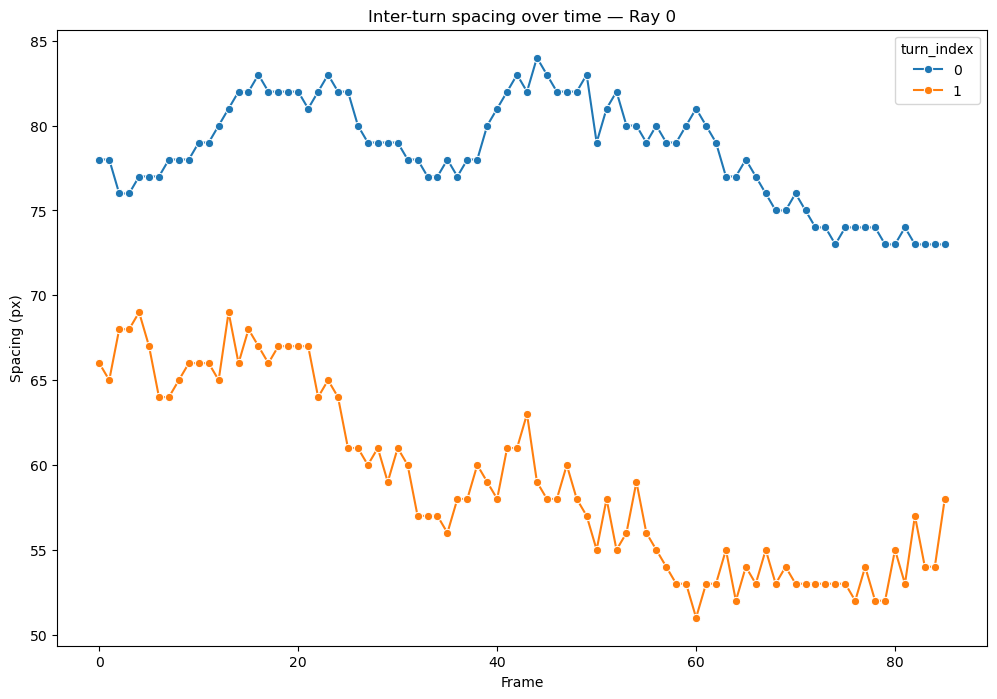

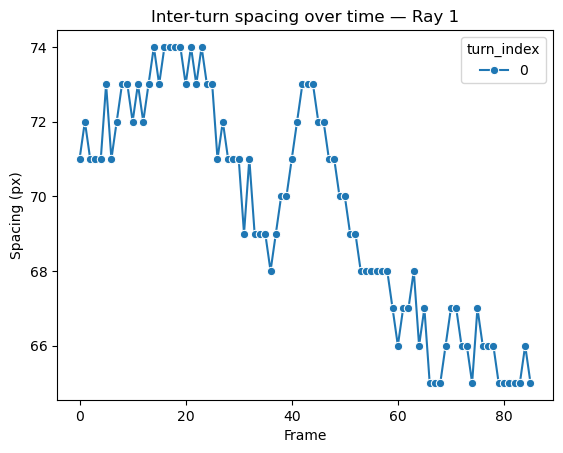

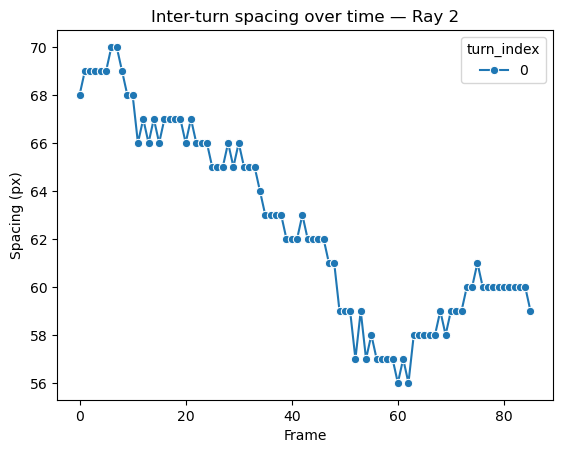

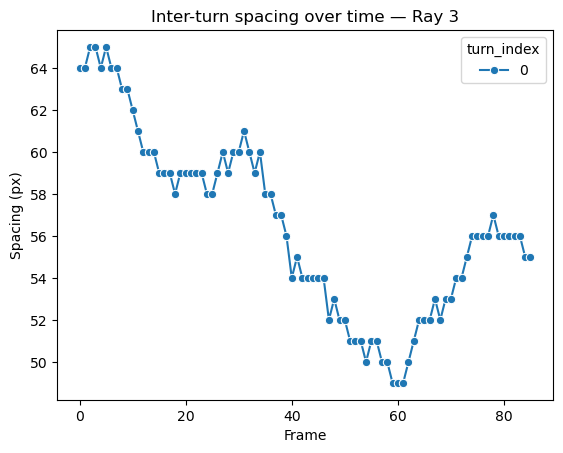

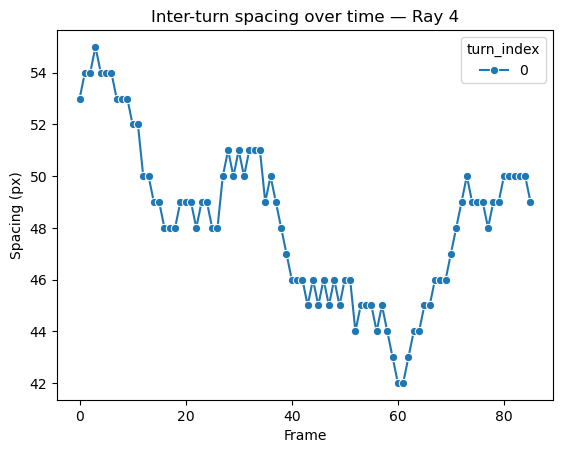

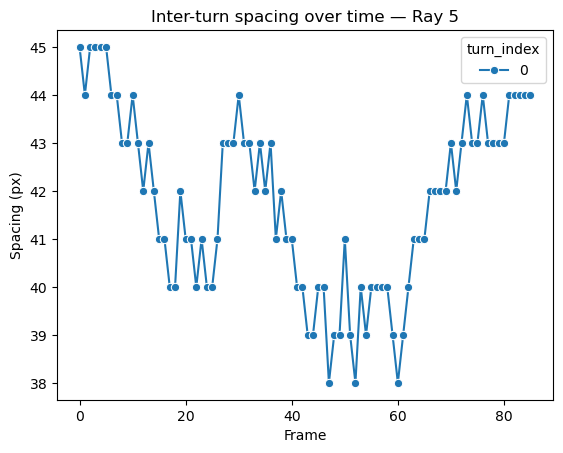

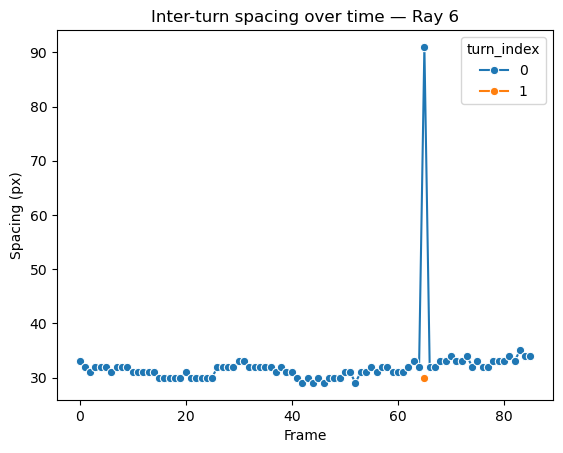

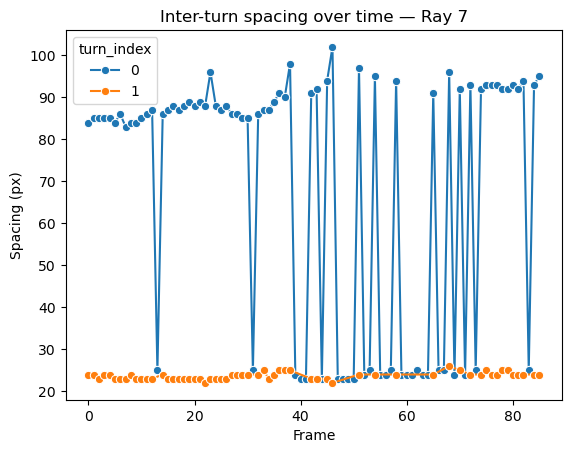

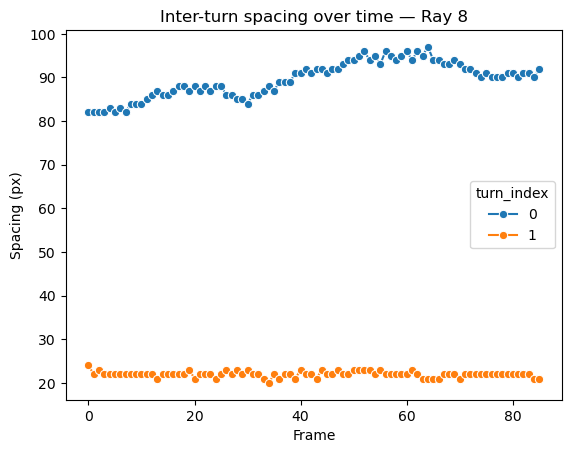

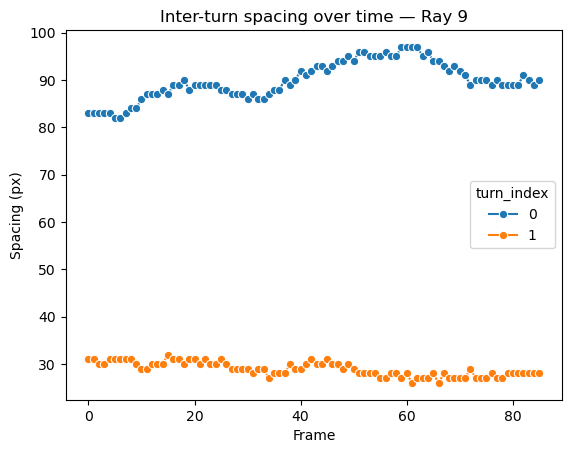

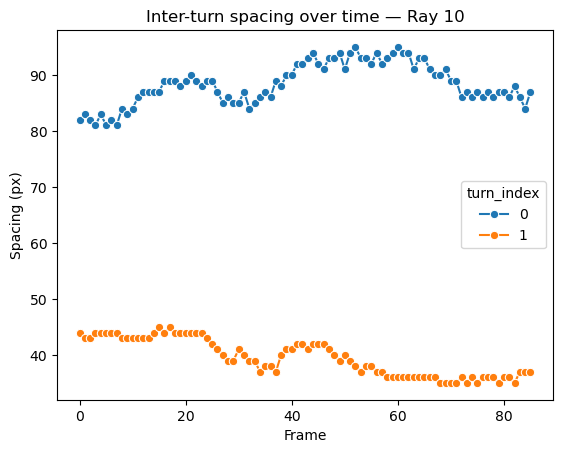

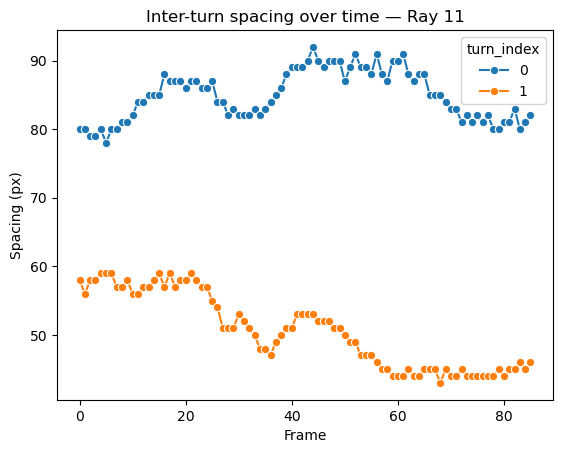

In [16]:
#plot the inter turn spacing -> careful sometimes spiral moves out of ray so turn definition changes

num_rays = df_spacing["ray"].max() + 1

plt.figure(figsize=(12, 8))
for r in range(num_rays):
    subset = df_spacing[df_spacing["ray"] == r]
    sns.lineplot(
        data=subset,
        x="frame",
        y="spacing",
        hue="turn_index",
        marker="o"
    )
    plt.title(f"Inter-turn spacing over time — Ray {r}")
    plt.xlabel("Frame")
    plt.ylabel("Spacing (px)")
    plt.show()


C:\Users\yarab\AppData\Local\Temp\ipykernel_30844\4148740762.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")


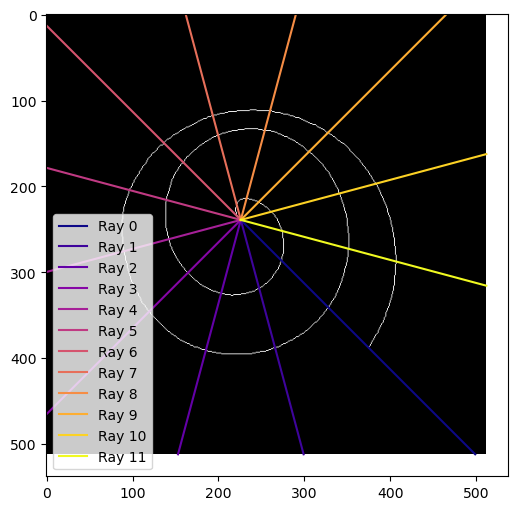

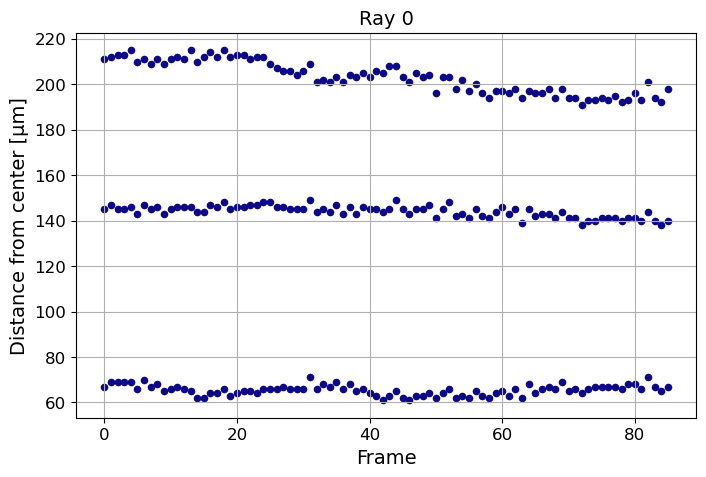

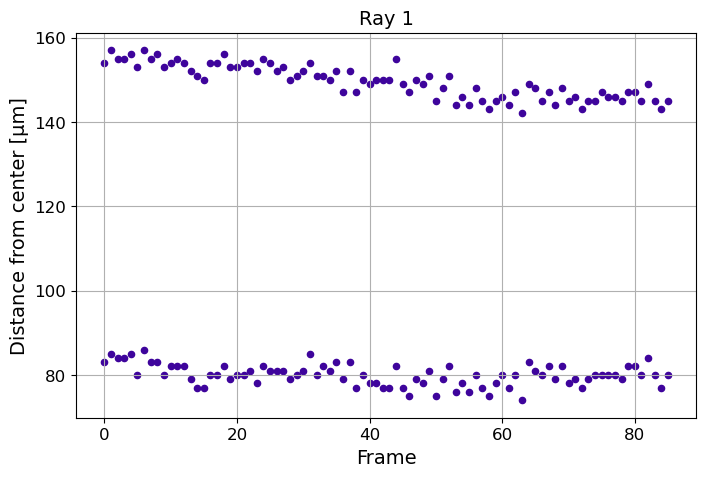

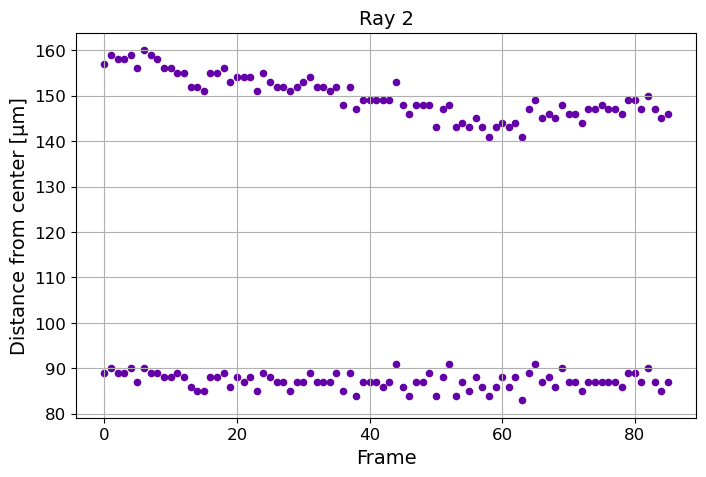

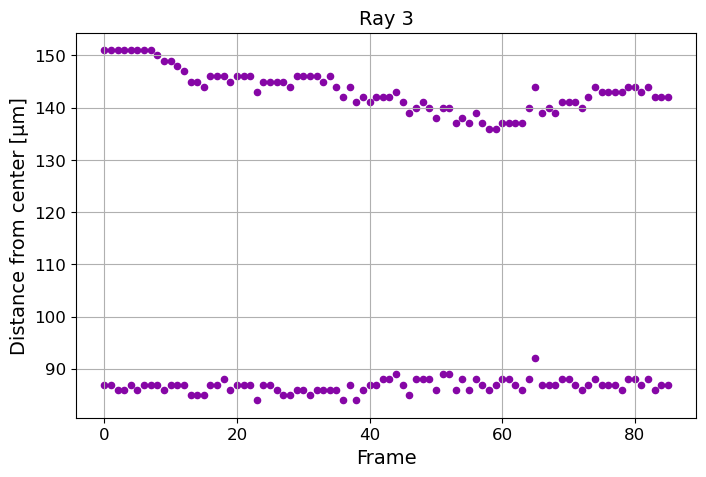

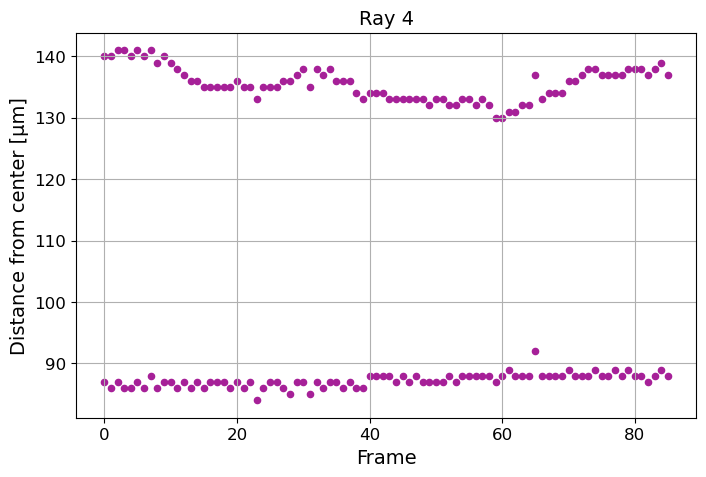

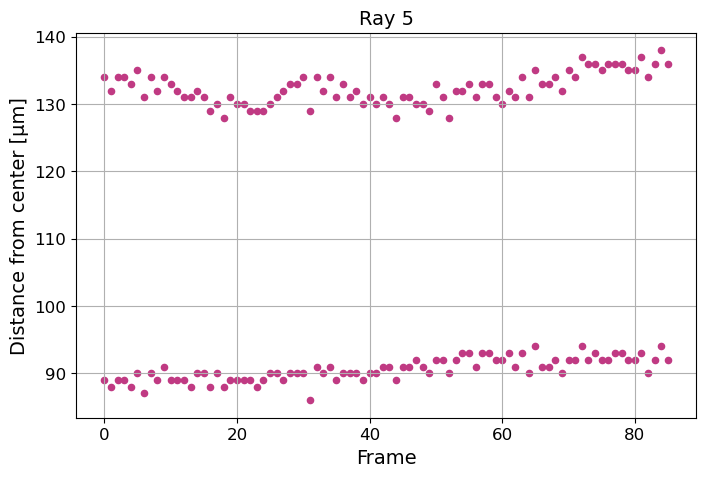

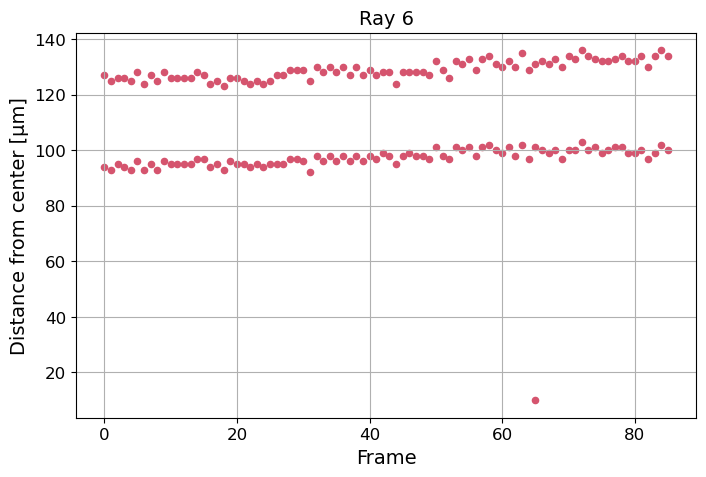

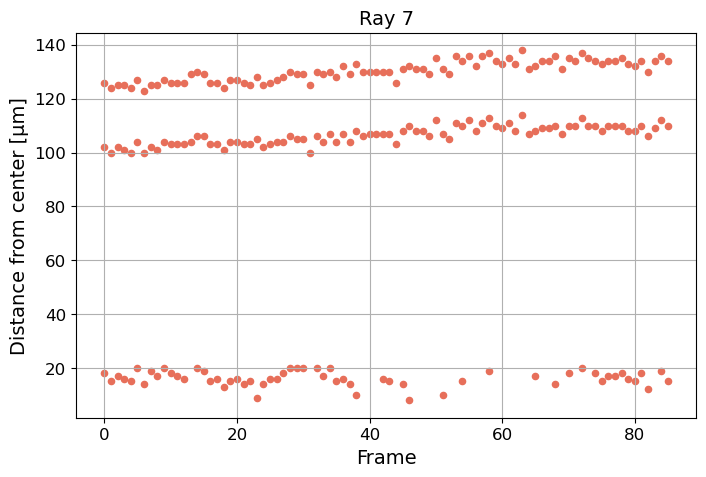

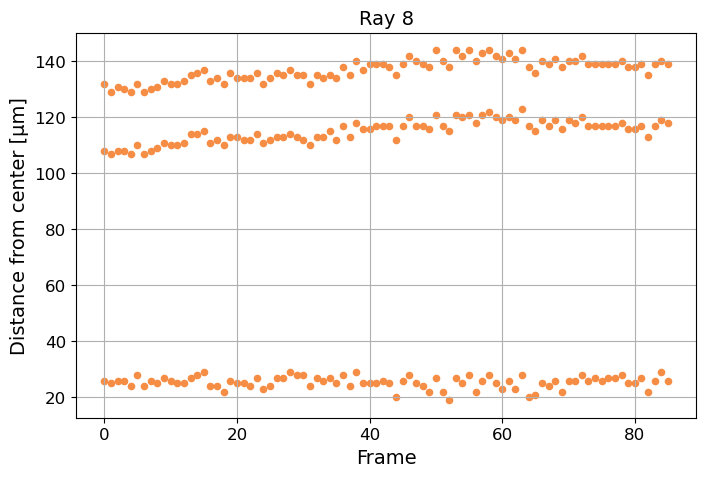

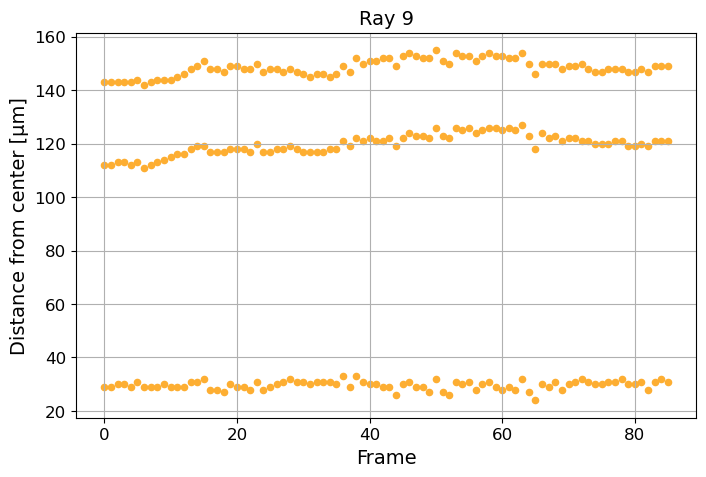

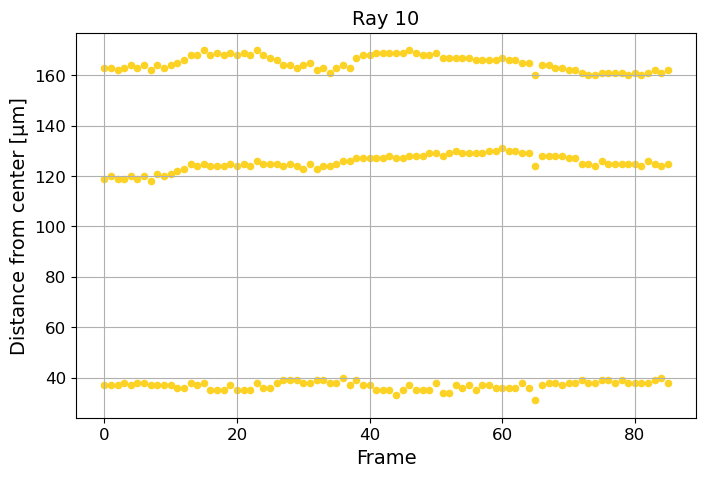

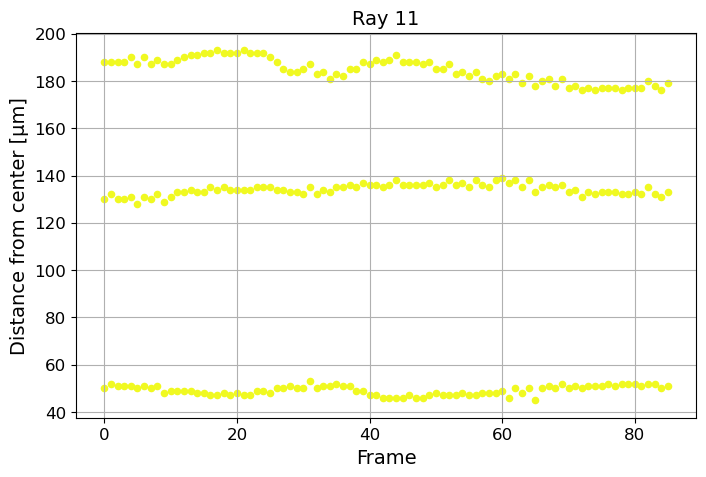

In [17]:
#generate images in correct color map
num_rays = 12

# Use plasma colormap and sample 12 evenly spaced colors
cmap = cm.get_cmap("plasma")
colors = [cmap(i / (num_rays - 1)) for i in range(num_rays)]

# colors now contains 12 distinct RGBA tuples

ends = find_endpoints(skel_stack[0])

inner, outer = sort_endpoints(*ends, skel_stack[0])

plt.figure(figsize=(6,6))
plt.imshow(skel_stack[0], cmap="gray")

for i, dst in enumerate(destinations):
    plt.plot([inner[0], dst[0]], [inner[1], dst[1]],
             color=colors[i], label=f"Ray {i}")

plt.legend()
plt.show()

for r in range(num_rays):
    times = [tp[0] for tp in ray_peaks_over_time[r]]
    distances = [tp[1] for tp in ray_peaks_over_time[r]]

    plt.figure(figsize=(8,5))
    plt.scatter(times, distances, color=colors[r], s=20)
    #plt.plot(times, distances, color=colors[r], alpha=0.7)

    plt.xlabel("Frame", fontsize=14)
    plt.ylabel("Distance from center [µm]", fontsize=14)
    plt.title(f"Ray {r}", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()




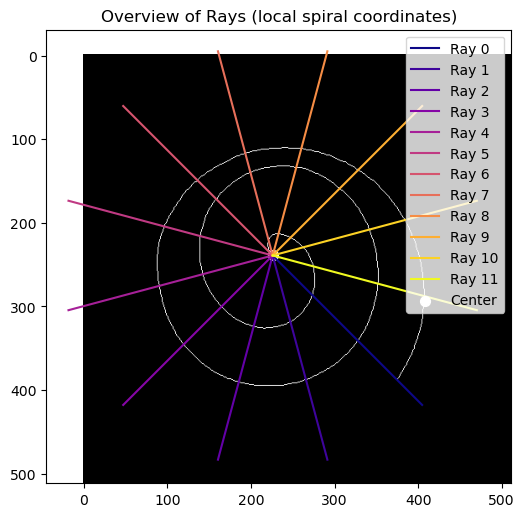

In [18]:
#Rearrange the spiral so the inner center is always overlayed to dismiss translation and only look at deformation

# inner = center of the spiral
# outer = point along ray 0 (first endpoint), should be above inner

# Define local origin at inner
origin = np.array(inner)  # (x, y)

# Vector from inner to outer defines the y-axis (ray 0)
v0 = np.array(outer) - np.array(inner)
v0_length = np.linalg.norm(v0)
v0_unit = v0 / v0_length  # normalized direction for ray 0

# Orthogonal vector to v0 defines x-axis
v1_unit = np.array([-v0_unit[1], v0_unit[0]])  # 90° rotation

num_rays = 12
ray_angles = np.deg2rad(np.arange(0, 360, 360/num_rays))  # 0° = ray 0

ray_length = v0_length * 1.2  # scale rays for visualization

destinations_local = []
for theta in ray_angles:
    # rotated vector: cos(theta) * v0_unit + sin(theta) * v1_unit
    direction = np.cos(theta) * v0_unit + np.sin(theta) * v1_unit
    dst = origin + ray_length * direction
    destinations_local.append(dst)

destinations_local = np.array(destinations_local)

plt.figure(figsize=(6,6))
plt.imshow(skel_stack[0], cmap="gray")

for i, dst in enumerate(destinations_local):
    plt.plot([origin[0], dst[0]], [origin[1], dst[1]],
             color=colors[i], label=f"Ray {i}")

plt.scatter(origin[0], origin[1], color='white', s=50, marker='o', label='Center')
plt.legend()
plt.title("Overview of Rays (local spiral coordinates)")
plt.show()



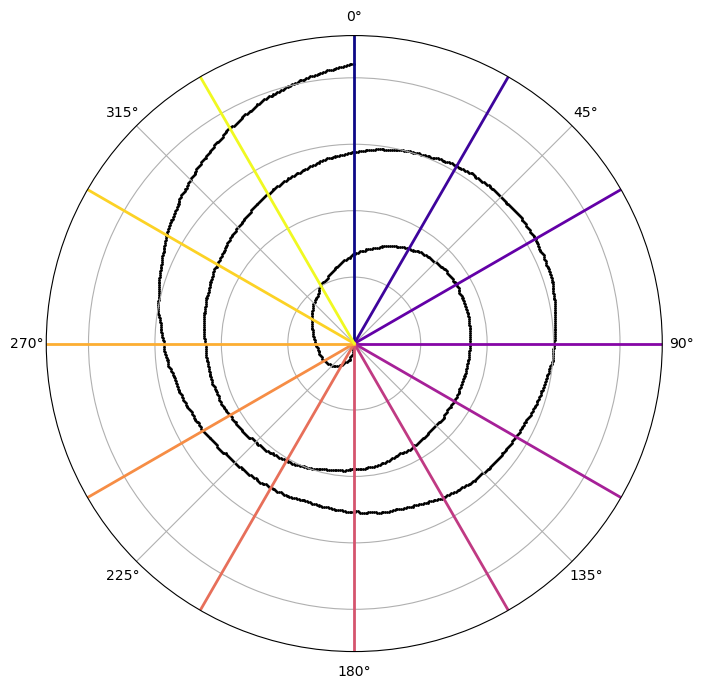

In [19]:
# ---- Inputs ----
# skel_stack[0]     # binary skeleton image
# inner, outer      # endpoints as (x, y)
# num_rays = 12
# colors            # list of colors for rays (plasma)

inner = np.array(inner)
outer = np.array(outer)

# Compute vector from inner → outer
v = outer - inner
v_len = np.linalg.norm(v)
phi = np.arctan2(v[1], v[0])    # angle of v in image coordinates

# We want ray 0 to be angle 0° (up) in polar plot.
# So rotate by angle_rot so that v points to 90° (=pi/2)
angle_rot = (np.pi/2) - phi

# Rotation matrix
cosr, sinr = np.cos(angle_rot), np.sin(angle_rot)
R = np.array([[cosr, -sinr],
              [sinr,  cosr]])

#-----------------------------------------------------------
#   STEP 1 — Convert skeleton pixels to polar coordinates
#-----------------------------------------------------------

# Get (x,y) coordinates of all skeleton pixels
ys, xs = np.where(skel_stack[0] > 0)
pts = np.vstack((xs, ys)).T  # shape (N,2)

# Shift to inner-centered coordinates
shifted = pts - inner

# Rotate into local coordinates
rotated = shifted @ R.T   # shape (N,2)

# Polar coordinates
theta = np.arctan2(rotated[:,0], rotated[:,1])  # careful: x,y swapped to keep 0° = up
r = np.sqrt(rotated[:,1]**2 + rotated[:,0]**2)

# Normalize theta to [0, 2π)
theta = ((-theta) + 2*np.pi) % (2*np.pi)

#-----------------------------------------------------------
#   STEP 2 — Compute ray angles
#-----------------------------------------------------------
ray_angles_deg = np.arange(0, 360, 360/num_rays)
ray_angles_rad = np.deg2rad(ray_angles_deg)
ray_thetas_plot = ((ray_angles_rad) + 2*np.pi) % (2*np.pi)

#-----------------------------------------------------------
#   STEP 3 — Polar plot
#-----------------------------------------------------------
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="polar")

# Configure polar orientation:
ax.set_theta_zero_location("N")  # 0° at top
ax.set_theta_direction(-1)       # clockwise increasing

# Plot skeleton in polar coordinates
ax.scatter(theta, r, c='black', s=1, alpha=1)

# Set radial limit for polar plot
outer_circle = np.max(r) * 1.1

for i, th in enumerate(ray_thetas_plot):
    ax.plot([th, th], [0, outer_circle], color=colors[i], lw=2)

#enforce radial limits explicitly so outer_circle is the outer ring
ax.set_ylim(0.0, outer_circle)

# Compute outer in polar coords for verification
outer_shift = outer - inner
outer_rot = R.dot(outer_shift)
outer_r = np.sqrt(outer_rot[0]**2 + outer_rot[1]**2)
outer_theta = (np.arctan2(outer_rot[0], outer_rot[1]) + 2*np.pi) % (2*np.pi)

#ax.set_title("Spiral in Polar Coordinates (Ray 0 = 0° = Up)", fontsize=12)
ax.set_yticklabels([])  # hide radius labels (optional)


plt.show()


In [20]:
#Overview of movements

# Safety: convert to lists/arrays
T = len(skel_stack)
# Build arrays of inner/outer for each frame using your sort_endpoints function result.
# Assuming ends_stack[t] returns two coords in (x,y) order: [endA, endB]
inners = []
outers = []
for t in range(T):
    e = ends_stack[t]
    if len(e) < 2:
        raise RuntimeError(f"Frame {t} has fewer than 2 endpoints.")
    # decide which is inner/outer: reuse your sort_endpoints if needed
    inner_t, outer_t = sort_endpoints(np.array(e[0]), np.array(e[1]), skel_stack[t])
    inners.append(np.array(inner_t))
    outers.append(np.array(outer_t))

# Precompute polar coords for every frame (theta in radians, r in pixels)
all_theta = []   # list of arrays
all_r = []
all_outer_r = []  # store each frame's outer radius for info

for t in range(T):
    inner = inners[t]
    outer = outers[t]

    # rotation that maps inner->outer to local +y (up)
    v = outer - inner
    phi = np.arctan2(v[1], v[0])
    angle_rot = (np.pi/2) - phi
    cosr, sinr = np.cos(angle_rot), np.sin(angle_rot)
    R = np.array([[cosr, -sinr],
                  [sinr,  cosr]])

    # skeleton pixel coords (x,y)
    ys, xs = np.nonzero(skel_stack[t] > 0)
    pts = np.vstack((xs, ys)).T    # (N,2)

    # shift & rotate
    shifted = pts - inner
    rotated = shifted @ R.T        # local coords (x', y')

    # polar coords with 0 = local +y (use arctan2(x', y'))
    theta_raw = np.arctan2(rotated[:, 0], rotated[:, 1])
    r = np.hypot(rotated[:, 0], rotated[:, 1])

    # make angles increase CLOCKWISE (your requested direction)
    theta = ((-theta_raw) + 2*np.pi) % (2*np.pi)

    all_theta.append(theta)
    all_r.append(r)

    # outer in same coords
    outer_shift = outer - inner
    outer_rot = R.dot(outer_shift)
    outer_r = np.hypot(outer_rot[0], outer_rot[1])
    all_outer_r.append(outer_r)

# Choose a numeric outer-circle radius for the polar axes so all frames fit nicely
max_r_all = max(r.max() if r.size>0 else 0.0 for r in all_r)
outer_circle = max_r_all * 1.5 if max_r_all > 0 else 100.0

# --- Plotting function for interactive viewer ---
def plot_all_frames_highlight(frame_idx=0,
                              overlay_alpha=0.08,
                              highlighted_color='black',
                              overlay_color='gray'):
    """
    overlay_alpha: transparency for the faint overlay of all frames
    frame_idx: index of the frame to highlight on top
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='polar')

    # polar orientation: 0 at top, clockwise increasing
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    # Plot overlay of all frames (faint)
    for t in range(T):
        theta = all_theta[t]
        r = all_r[t]
        if theta.size == 0:
            continue
        ax.scatter(theta, r, s=1, c=overlay_color, alpha=overlay_alpha, linewidths=0, zorder=1)

    # Highlight selected frame much darker/stronger
    theta_h = all_theta[frame_idx]
    r_h = all_r[frame_idx]
    ax.scatter(theta_h, r_h, s=2, c=highlighted_color, alpha=1.0, linewidths=0, zorder=3)

    # Mark the outer endpoint of the highlighted frame at 0° (should be near theta=0)
    # compute outer theta/r for that frame for visualization
    inner = inners[frame_idx]
    outer = outers[frame_idx]
    v = outer - inner
    phi = np.arctan2(v[1], v[0])
    angle_rot = (np.pi/2) - phi
    cosr, sinr = np.cos(angle_rot), np.sin(angle_rot)
    R = np.array([[cosr, -sinr],
                  [sinr,  cosr]])
    outer_shift = outer - inner
    outer_rot = R.dot(outer_shift)
    outer_r = np.hypot(outer_rot[0], outer_rot[1])
    outer_theta_raw = np.arctan2(outer_rot[0], outer_rot[1])
    outer_theta = ((-outer_theta_raw) + 2*np.pi) % (2*np.pi)

    # show a marker for this frame outer (cyan) and center
    ax.scatter([outer_theta], [outer_r], c='cyan', s=60, edgecolor='k', zorder=4, label='outer (frame {})'.format(frame_idx))
    ax.scatter([0.0], [0.0], c='white', s=80, edgecolor='k', zorder=5, label='inner (origin)')

    # Force consistent radial span for all frames
    ax.set_ylim(0.0, outer_circle)
    ax.set_yticklabels([])

    ax.set_title(f"All frames overlay — highlighted frame {frame_idx}", fontsize=12)
    ax.legend(loc='upper right')
    plt.show()

# --- Show initial plot and interactive slider ---
# a slider with integer frames
interact(plot_all_frames_highlight, frame_idx=IntSlider(min=0, max=T-1, step=1, value=0),
         overlay_alpha=(0.01, 0.5, 0.01),
         highlighted_color=['black'],
         overlay_color=['gray'])


interactive(children=(IntSlider(value=0, description='frame_idx', max=85), FloatSlider(value=0.08, description…

<function __main__.plot_all_frames_highlight(frame_idx=0, overlay_alpha=0.08, highlighted_color='black', overlay_color='gray')>

C:\Users\yarab\AppData\Local\Temp\ipykernel_30844\2959612056.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")


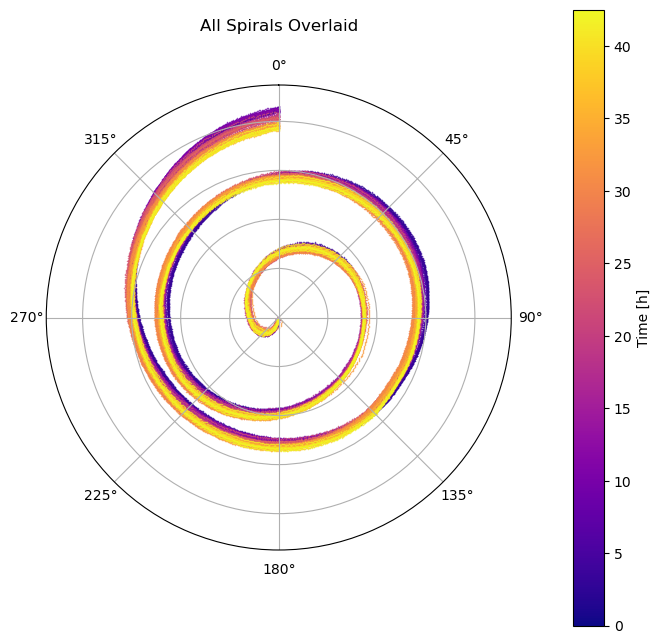

In [23]:
frame_interval_hr = 0.5  # 30 minutes
time_hours = np.arange(T) * frame_interval_hr
#Visualization of Spiral deformation over time

# ---------------------------
# Precompute polar coords 
# ---------------------------

T = len(branch_images)
all_theta = []
all_r = []
max_r_all = 0

for t in range(T):

    inner = np.array(inners[t])
    outer = np.array(outers[t])

    # Compute rotation so inner → outer becomes 0° (up)
    v = outer - inner
    phi = np.arctan2(v[1], v[0])
    angle_rot = (np.pi/2) - phi

    cosr, sinr = np.cos(angle_rot), np.sin(angle_rot)
    R = np.array([[cosr, -sinr],
                  [sinr,  cosr]])

    # skeleton pixel coords (x,y)
    ys, xs = np.nonzero(branch_images[t] > 0)
    pts = np.vstack((xs, ys)).T

    # shift & rotate
    shifted = pts - inner
    rotated = shifted @ R.T

    # polar with 0° = up
    theta_raw = np.arctan2(rotated[:,0], rotated[:,1])
    r = np.hypot(rotated[:,0], rotated[:,1])

    # clockwise angles
    theta = ((-theta_raw) + 2*np.pi) % (2*np.pi)

    max_r_all = max(max_r_all, r.max() if r.size else 0)

    all_theta.append(theta)
    all_r.append(r)

# ---------------------------
# Plot all spirals in plasma colormap
# ---------------------------

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='polar')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# plasma colormap sampled over T frames
cmap = cm.get_cmap("plasma")
frame_colors = [cmap(i/(T-1)) for i in range(T)]

for t in range(T):
    ax.scatter(all_theta[t], all_r[t],
               s=1.2,
               color=frame_colors[t],
               alpha=0.7,
               linewidths=0)

# consistent radial limit
ax.set_ylim(0, max_r_all * 1.1)
ax.set_yticklabels([])

ax.set_title("All Spirals Overlaid", fontsize=12, x=0.5, y=1.1)

norm = mpl.colors.Normalize(vmin=time_hours.min(),
                            vmax=time_hours.max())

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label("Time [h]")

plt.show()


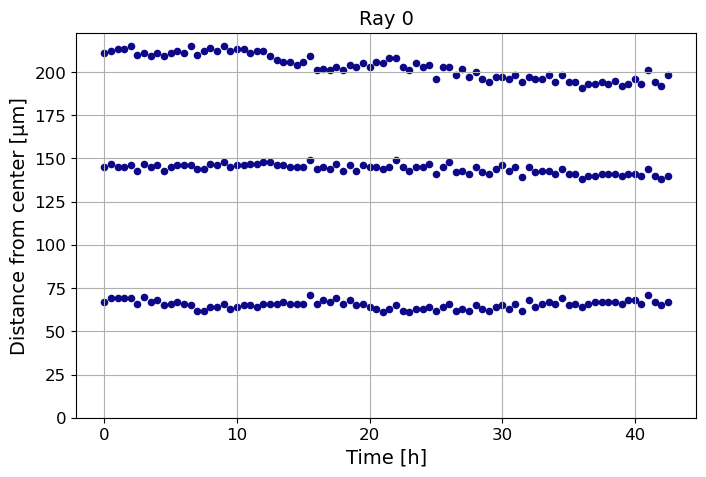

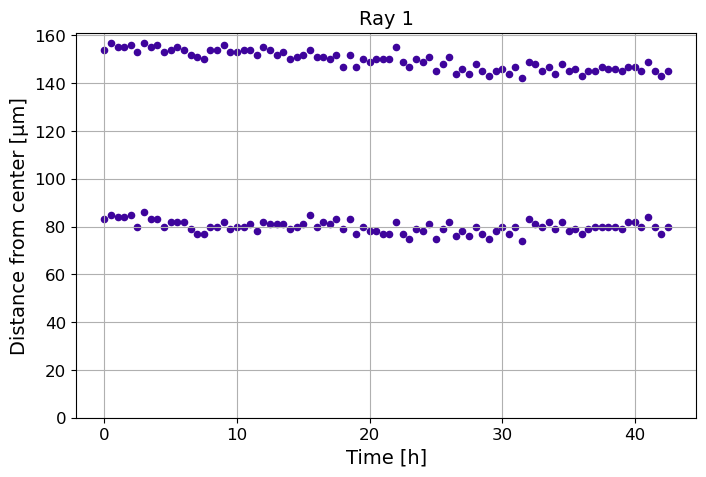

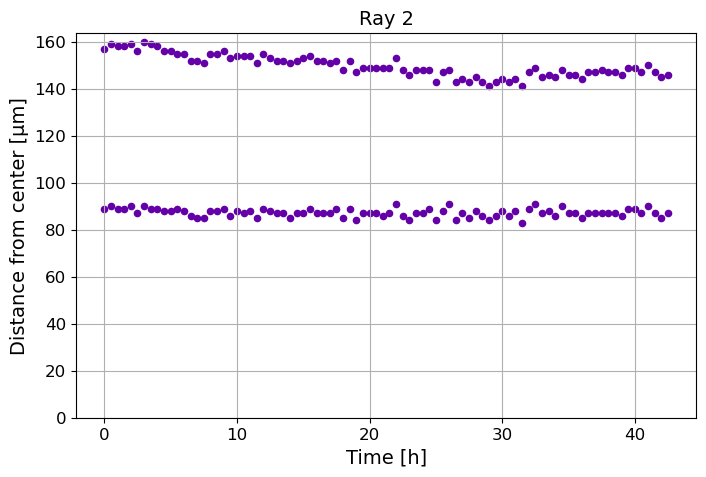

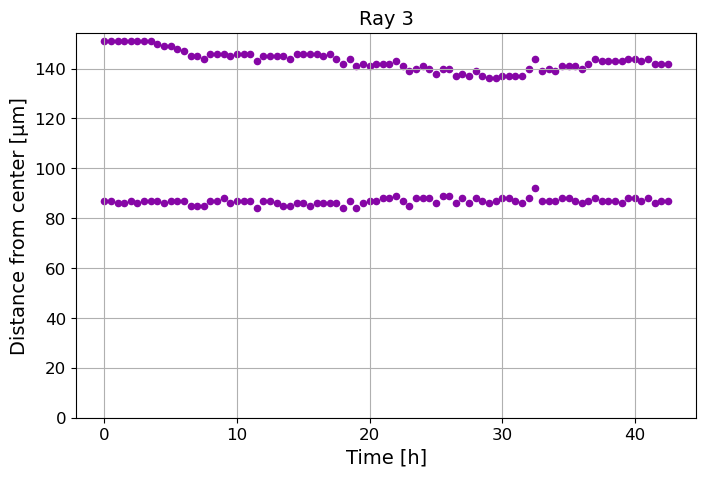

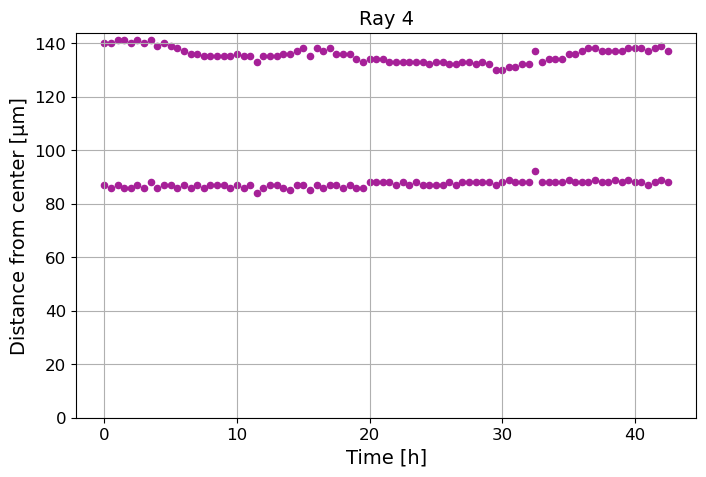

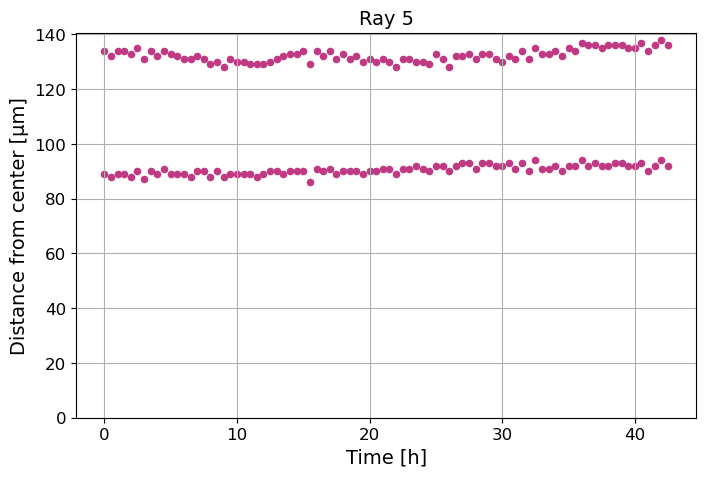

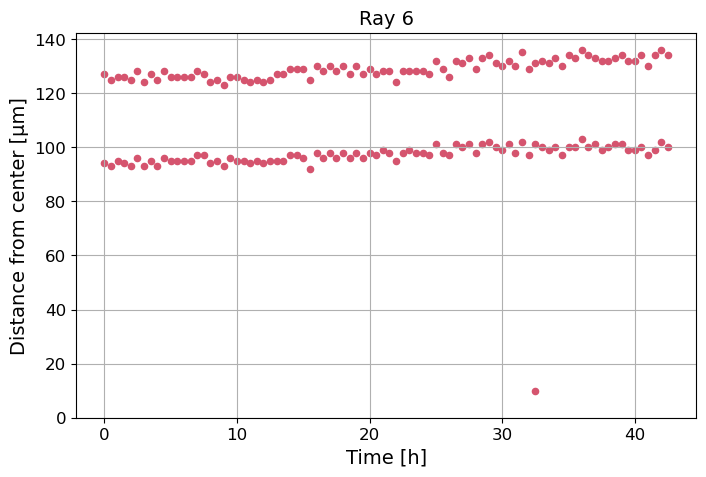

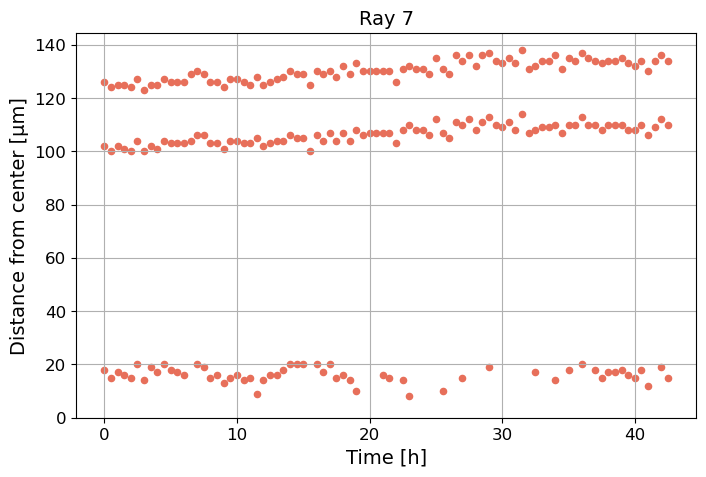

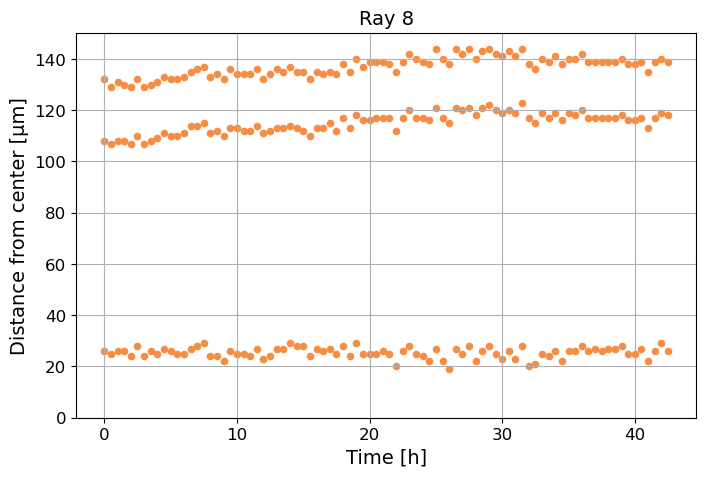

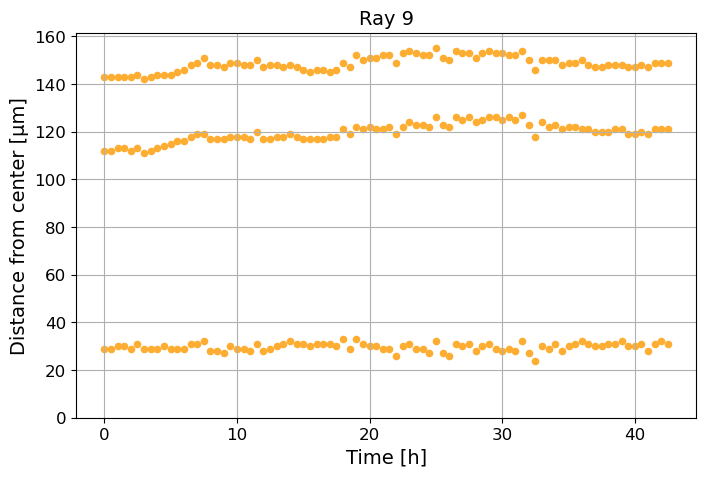

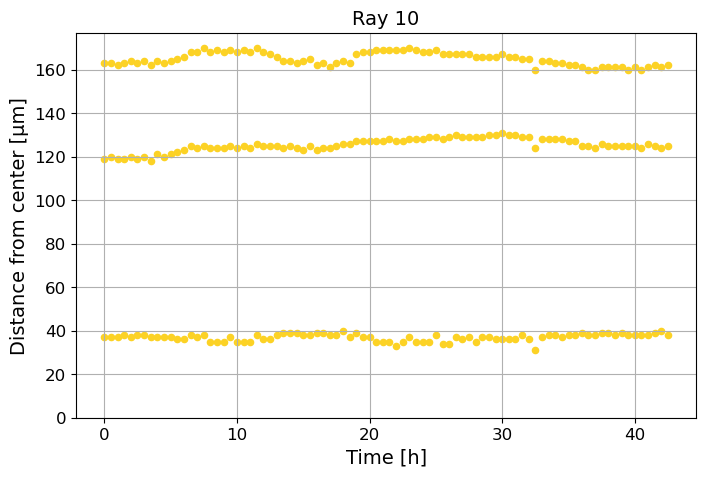

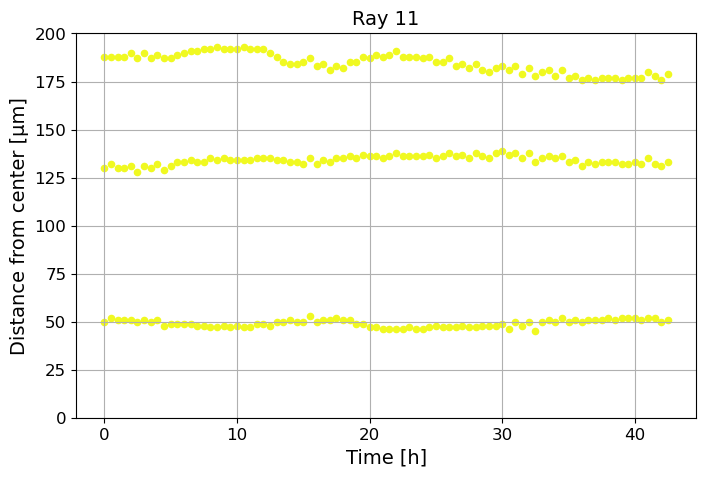

In [22]:
frame_interval_min = 30
frame_interval_hr = frame_interval_min / 60

for r in range(num_rays):
    frames = [tp[0] for tp in ray_peaks_over_time[r]]
    distances = [tp[1] for tp in ray_peaks_over_time[r]]

    # Convert frames → time (hours)
    times_hr = [f * frame_interval_hr for f in frames]

    plt.figure(figsize=(8,5))
    plt.scatter(times_hr, distances, color=colors[r], s=20)

    plt.xlabel("Time [h]", fontsize=14)
    plt.ylabel("Distance from center [µm]", fontsize=14)
    plt.title(f"Ray {r}", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.show()

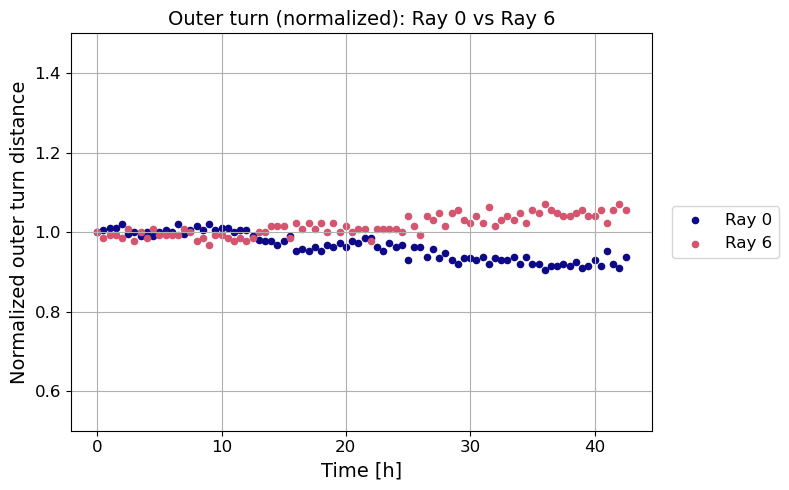

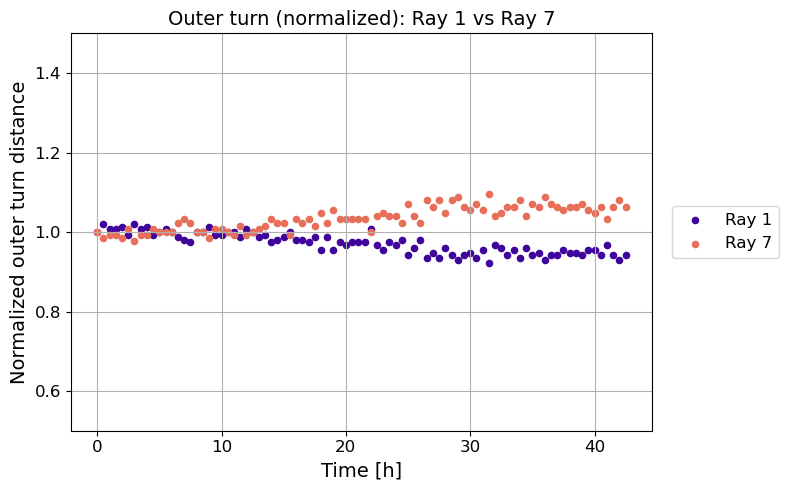

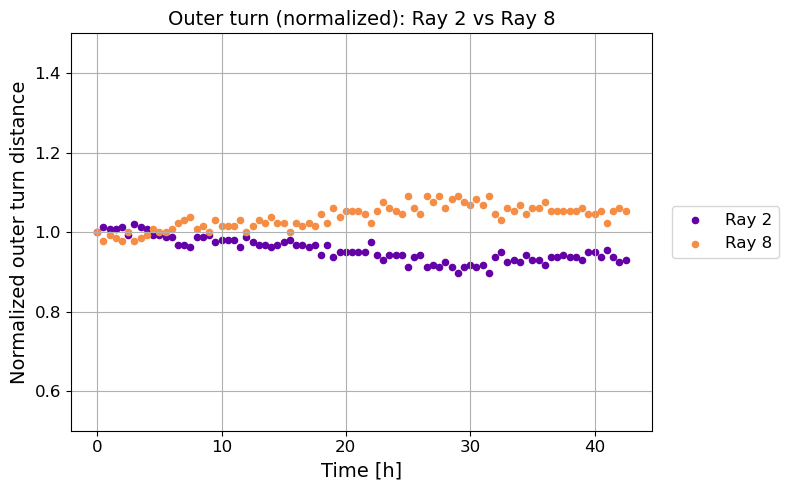

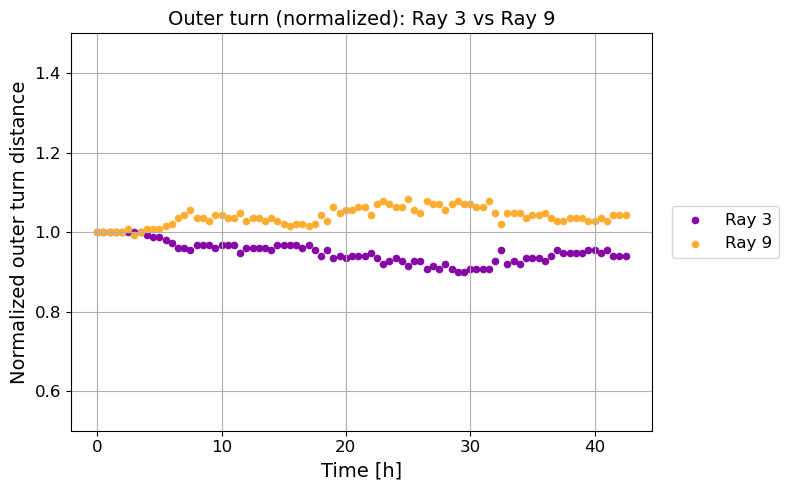

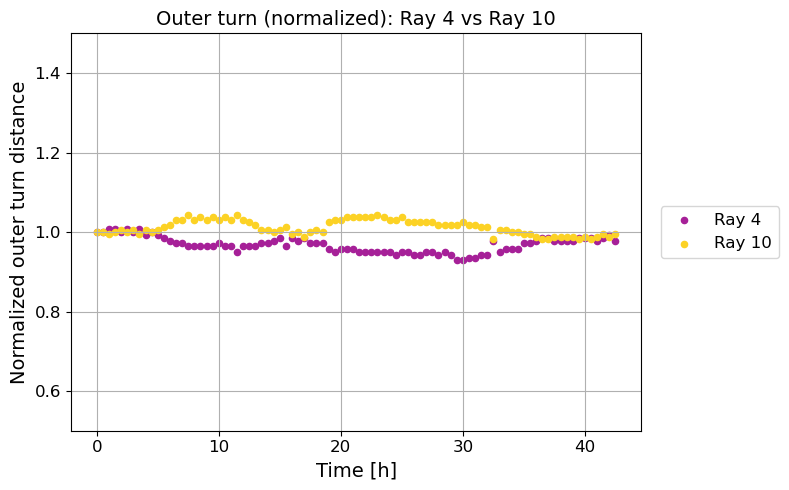

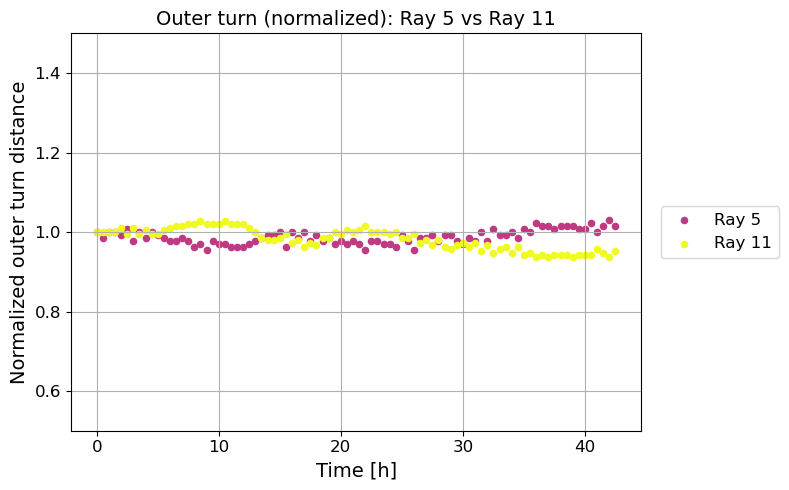

In [25]:
outer_turn_idx = (
    df_spacing
    .groupby(["frame", "ray"])["turn_index"]
    .max()
    .reset_index()
    .rename(columns={"turn_index": "outer_turn_index"})
)

rows = []

for _, row in outer_turn_idx.iterrows():
    t = int(row["frame"])
    r = int(row["ray"])
    i = int(row["outer_turn_index"])

    peaks = peaks_all[t][r]

    # outermost peak position (distance from center)
    outer_distance = peaks[i + 1]

    rows.append({
        "frame": t,
        "ray": r,
        "distance": outer_distance
    })

df_outer_distance = pd.DataFrame(rows)

df_outer_distance["time_hr"] = df_outer_distance["frame"] * frame_interval_hr


df_outer_distance = df_outer_distance.sort_values(["ray", "frame"])

df_outer_distance["distance_norm"] = (
    df_outer_distance["distance"]
    / df_outer_distance.groupby("ray")["distance"].transform("first")
)

df_outer_distance.groupby("ray").first()[["distance", "distance_norm"]]

ray_pairs = [(0, 6), (1, 7), (2, 8), (3, 9), (4,10), (5,11)]

for r1, r2 in ray_pairs:

    plt.figure(figsize=(8, 5))

    for r in (r1, r2):
        sub = df_outer_distance[df_outer_distance["ray"] == r]

        plt.scatter(
            sub["time_hr"],
            sub["distance_norm"],
            color=colors[r],
            s=20,
            label=f"Ray {r}"
        )

    plt.xlabel("Time [h]", fontsize=14)
    plt.ylabel("Normalized outer turn distance", fontsize=14)
    plt.title(f"Outer turn (normalized): Ray {r1} vs Ray {r2}", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.ylim(0.5, 1.5)

    plt.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        fontsize=12
    )

    plt.tight_layout()
    plt.show()


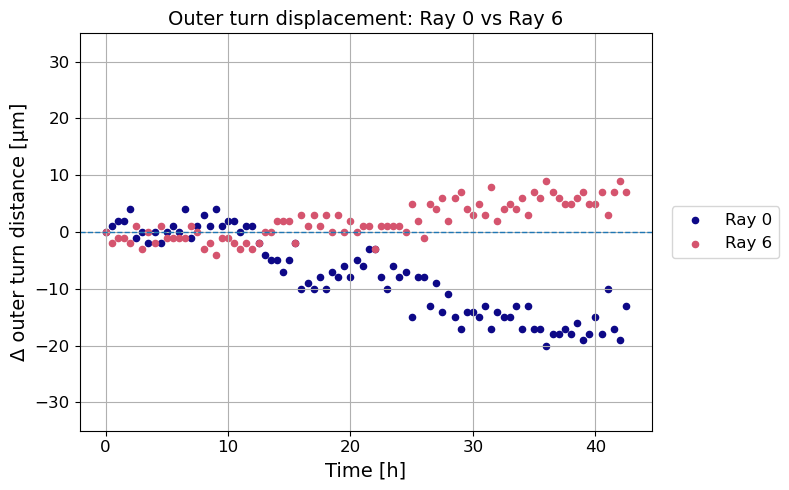

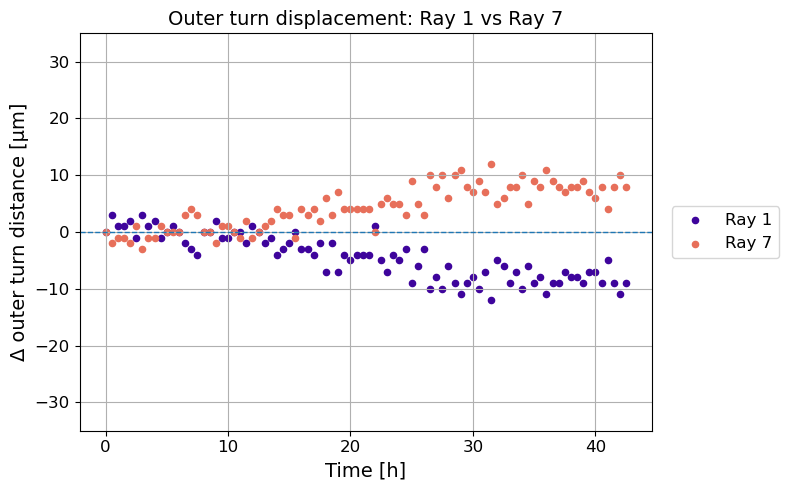

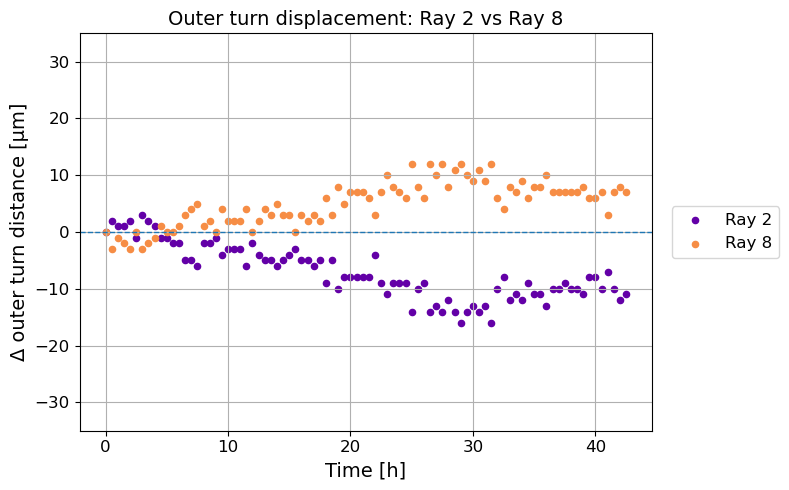

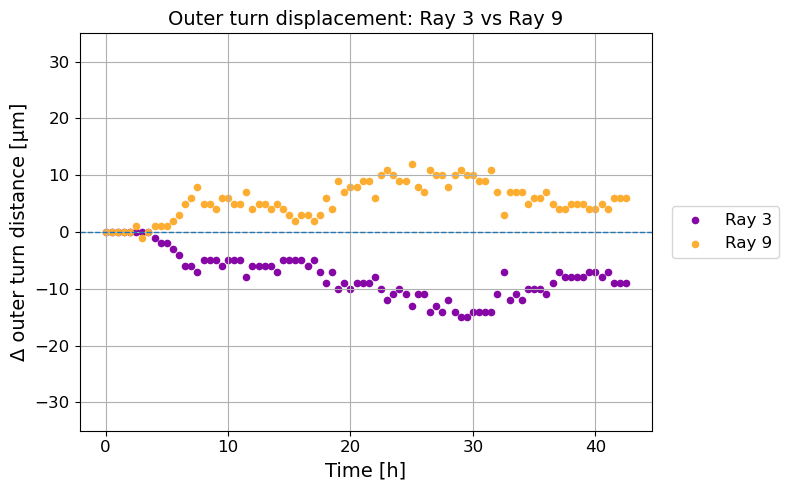

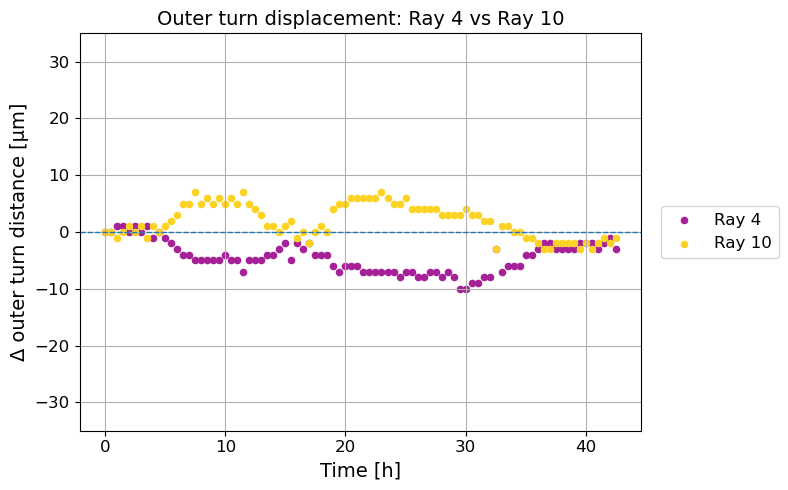

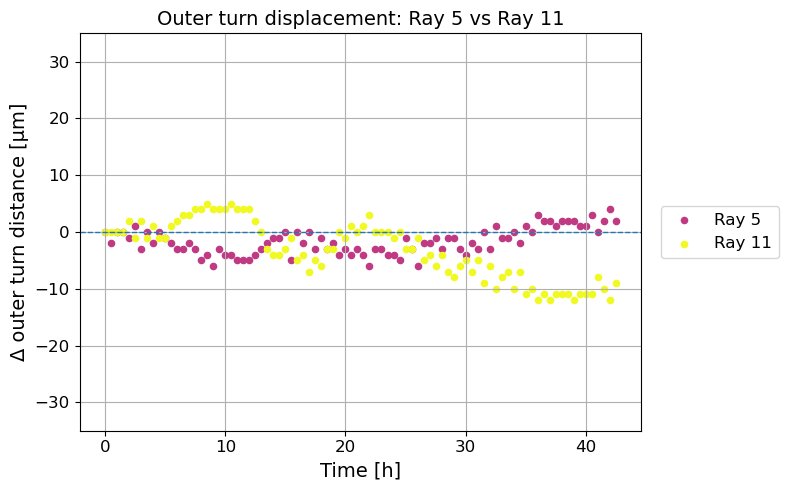

In [26]:
df_outer_distance = df_outer_distance.sort_values(["ray", "frame"])

df_outer_distance["distance_delta"] = (
    df_outer_distance["distance"]
    - df_outer_distance.groupby("ray")["distance"].transform("first")
)

ray_pairs = [(0, 6), (1, 7), (2, 8), (3, 9), (4,10), (5,11)]

for r1, r2 in ray_pairs:

    plt.figure(figsize=(8, 5))

    for r in (r1, r2):
        sub = df_outer_distance[df_outer_distance["ray"] == r]

        plt.scatter(
            sub["time_hr"],
            sub["distance_delta"],
            color=colors[r],
            s=20,
            label=f"Ray {r}"
        )

    plt.xlabel("Time [h]", fontsize=14)
    plt.ylabel("Δ outer turn distance [µm]", fontsize=14)
    plt.title(f"Outer turn displacement: Ray {r1} vs Ray {r2}", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)

    plt.axhline(0.0, linestyle="--", linewidth=1)
    plt.ylim(-35, +35)

    plt.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        fontsize=12
    )

    plt.tight_layout()
    plt.show()